In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import convertdate
from tqdm import tqdm
import matplotlib
import matplotlib.font_manager as fm

In [7]:
fm.fontManager.addfont('../references/cmunorm.ttf')
matplotlib.rcParams['font.family'] = 'CMU Concrete'
plt.rc('axes', unicode_minus=False)

In [32]:
main_df = pd.read_parquet('../data/RZ_processed.parquet')

In [10]:
df = pd.read_csv('../data/processed_data.tsv', sep='\t', encoding='utf8', na_values=pd.NA).convert_dtypes()
df.doc_date = pd.to_datetime(df.doc_date)
df.origin_date = pd.to_datetime(df.origin_date)
#df.delta = pd.to_timedelta(df.delta, unit='days')
df = df[df.delta.isin(range(0,120))]

In [4]:
places = pd.read_csv('../data/places.tsv', sep='\t', encoding='utf8')

In [13]:
delta = pd.read_csv('../data/average_times.tsv', sep='\t', encoding='utf8', index_col='Unnamed: 0')

In [102]:
def plot(names, rolling=1, savepath=None):

    fig = plt.figure(figsize=(15,7))

    for name in names:
        delta[name].rolling(rolling, min_periods=1).mean().reindex(range(1802,1889)).plot(label=name)

    plt.xticks(ticks=range(1802,1889), labels=[str(yr) if yr%5==0 else '' for yr in range(1802,1889)], size=14)
    plt.yticks(size=14)
    plt.ylabel('days', size=16)
    plt.grid(which='major', linewidth=1.2)                
    plt.legend(fontsize=14, loc='upper right',
               ncol=1 if len(names) < 11 else 2)
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')

    plt.show()

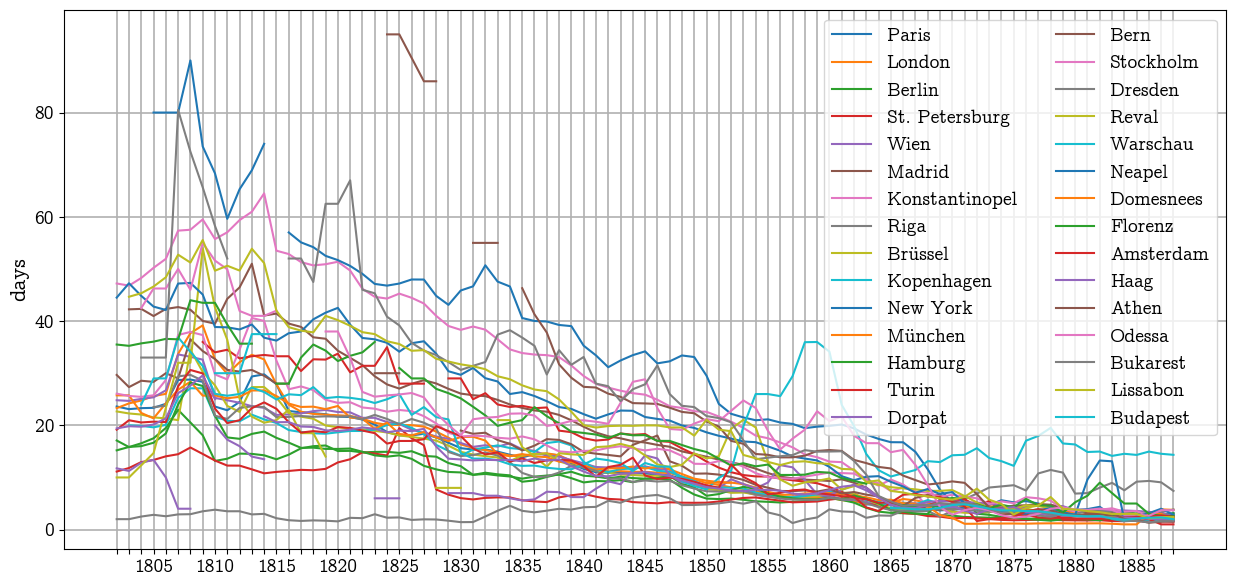

In [110]:
plot(places.placename[:30], rolling=3, savepath='../references/images/top_30.png')

In [90]:
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-0.5, 0.5, offsets.shape[0])
    jittered_offsets[:, 1] += np.random.uniform(-0.5, 0.5, offsets.shape[0])
    dots.set_offsets(jittered_offsets)
    
    
def plot_speed_distribution(place, savepath=None):
    
    plt.figure(figsize=(15,7))
    
    place_df = df[df.placename == place]
    dots = plt.scatter(x=place_df.doc_date.dt.year, y=place_df.delta, s=3, label=place, alpha=0.6)
    jitter_dots(dots)
        
    plt.xticks([i for i in range(1800, 1890) if i%5 == 0])
    plt.title(place, size=20)
    plt.ylabel('days', size=16)
    plt.ylim(0, 80)
    #plt.legend()
    plt.grid()
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
        
    plt.show()


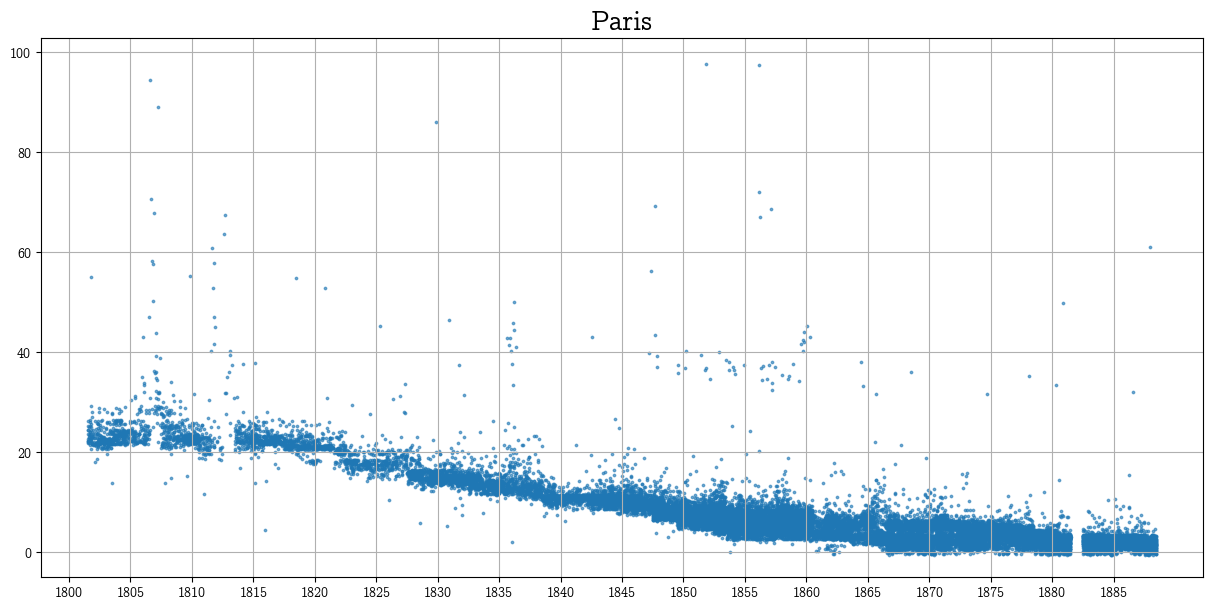

In [27]:
plot_speed_distribution('Paris')

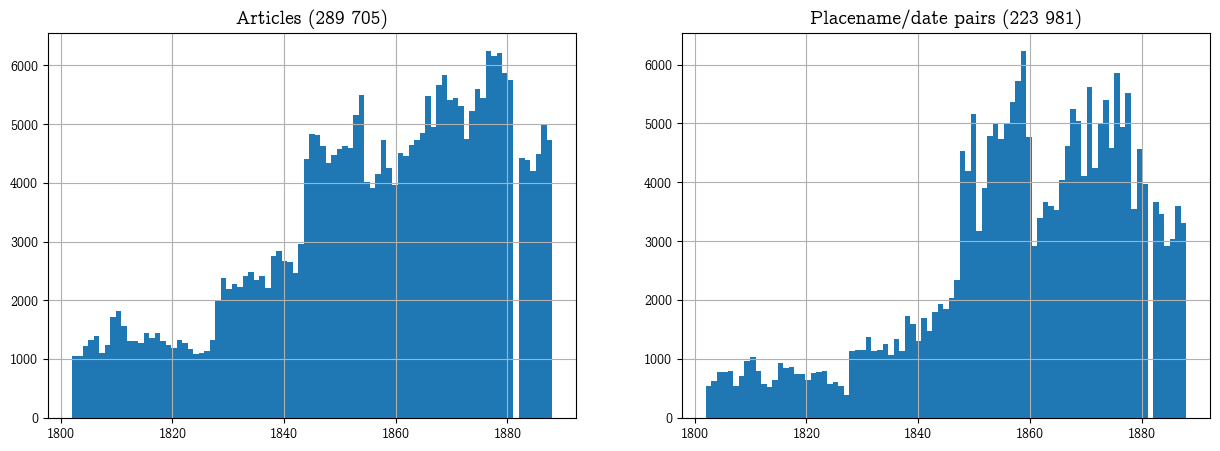

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

main_df.year.hist(ax=ax1, bins=87)
df.doc_date.dt.year.hist(ax=ax2, bins=87)

ax1.set_title('Articles (289 705)', fontsize=14)
ax2.set_title('Placename/date pairs (223 981)', fontsize=14)

plt.savefig('../references/images/articles_data.png', bbox_inches='tight')

plt.show()

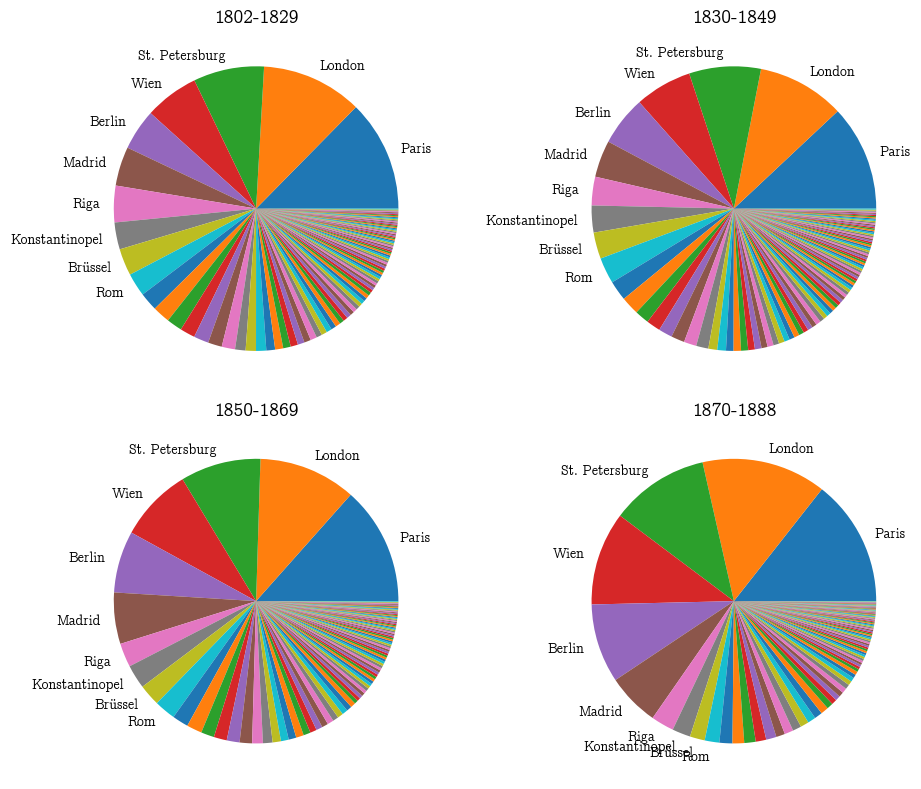

In [61]:
def pie_plot(timeranges, n_labels, savepath=None):
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    for ax, timerange in zip([axes[0][0], axes[0][1], axes[1][0], axes[1][1]], timeranges):
        data = df[df.doc_date.dt.year.isin(timerange)].placename.value_counts()[:100]
        labels = [label for label in data_early.index[:n_labels]] + ['']*(100-n_labels)
        data.plot.pie(ax=ax, labels=labels)
        
        ax.set_ylabel('')
        ax.set_title(f'{timerange[0]}-{timerange[-1]}', fontsize=14)
        
    fig.tight_layout()
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
        
    plt.show()
    

pie_plot([range(1802, 1830), range(1830, 1850), range(1850, 1870), range(1870, 1889)], 10,
        savepath='../references/images/pie_plots.png')

In [80]:
len(df.placename.unique())

367

In [84]:
df[['placename', 'doc_date', 'origin_date', 'delta']].sample(10).sort_values(by='doc_date')

,placename,doc_date,origin_date,delta
6289,Narwa,1810-07-23,1810-07-09,14
37716,Beirut,1842-09-03,1842-08-18,16
40488,St. Petersburg,1844-03-28,1844-03-24,4
53113,Paris,1849-01-25,1849-01-15,10
89702,Hannover,1857-02-01,1857-01-28,4
106839,Turin,1860-01-04,1859-12-23,12
170933,Odessa,1874-09-14,1874-09-13,1
180612,Wien,1876-08-13,1876-08-10,3
201459,Riga,1880-12-06,1880-10-21,46
214452,Madrid,1885-07-02,1885-07-01,1


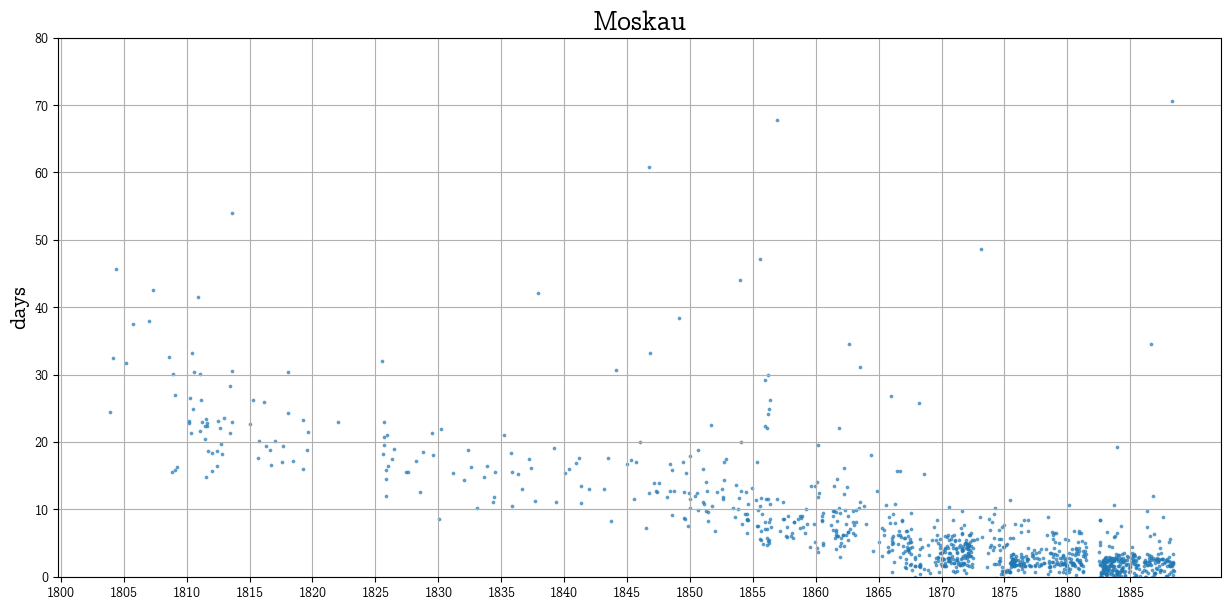

In [97]:
plot_speed_distribution('Moskau')

In [81]:
def convert_to_julian(year, month, day):
        
    try:
        day_jul = convertdate.julian.from_gregorian(year, month, day)
    except ValueError:
        return None
     
    print('converted')
    return pd.to_datetime(f'{str(day_jul[0])}-{str(day_jul[1])}-{str(day_jul[2])}', format='%Y-%m-%d', errors='coerce')

In [6]:
def verify_dates(ix, df, places, max_delay=120):
    
    """Function to find the logically correct date from the information found by the regular expression.
    Has different approaches depending on the number of dates and months detected. In the case of multiple
    possibilities, returns the earlier one (corresponding to the Julian calendar)."""
        
    placename, day, day2, month, month2, origin_year, doc_date = [value if type(value) != pd._libs.missing.NAType else None
                                          for value in
                                        df.loc[ix,['placename', 'day', 'day2', 'month', 'month2', 'origin_year', 'doc_date']].values]
    
    calendar = places.calendar[places.placename == placename].values[0]
    
    path = []
    
    # if day or month is missing
    if day is None or month is None:
        path.append(0)
        print(path)
        return pd.NA
    
    ### two dates, two months
    if None not in [day, day2, month, month2]:
        path.append(1)
        
        if origin_year:
            path.append(1.1)
            print(path)
            return min(
                pd.to_datetime(f'{str(origin_year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(origin_year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            )
            
        # exception for december/january  
        elif month == 1 and month2 == 12:
            path.append(1.2)
            if doc_date.month == 12:
                path.append(1.3)
                return pd.to_datetime(f'{str(doc_date.year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            else: 
                return pd.to_datetime(f'{str(doc_date.year-1)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
                        
        # if both months come after publication month, news is probably from last year
        elif month > doc_date.month and month2 > doc_date.month:
            
            possible_origin_dates = []
            for d, m in zip([day, day2], [month, month2]):
                origin_year = doc_date.year - 1
                possible_origin_dates.append(
                        pd.to_datetime(f'{str(origin_year)}-{m}-{d}', format='%Y-%m-%d', errors='coerce'))
            return min(possible_origin_dates)
        
        # normal proceeding
        else:
            # julian is the smaller one
            return min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            )
       
    
    ### two dates, one month
    elif day and day2 and month:
        
        if origin_year:
            return min(
                pd.to_datetime(f'{str(origin_year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(origin_year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
            )
        
        # if month is the same or precedes the publication month
        elif month == doc_date.month or month < doc_date.month:
            
            # julian is the smaller one
            return min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
            )
       
        # if month follows publication month
        elif month > doc_date.month:
            
            # formulate dates for both possibilities
            origin_date = min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'))
             
            # is the smaller one more than 12 days later than publication date?
            if origin_date - doc_date > pd.Timedelta(days=12):
                # so the news is from last year
                return origin_date - pd.DateOffset(years=1)
            else:
                # if not, it is probably a georgian date a few days ahead of the julian publication date
                return convert_to_julian(origin_date.year, origin_date.month, origin_date.day)

        else:
            pass # add something here?

            
    # one day, one month
    elif day and month:
        
        if origin_year:
            if calendar == 'j':
                return pd.to_datetime(f'{origin_year}-{month}-{day}',
                                             format='%Y-%m-%d', errors='coerce')

            elif calendar == 'g':
                return convert_to_julian(origin_year, month, day)
            
        else:
            if calendar == 'j':
                origin_date = pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}',
                                                 format='%Y-%m-%d', errors='coerce')
            
            elif calendar == 'g':
                origin_date = convert_to_julian(doc_date.year, month, day)
                
            
            if origin_date > doc_date:
                
                if doc_date - (origin_date - pd.DateOffset(1, 'year')) < pd.Timedelta(max_delay, 'days'):
                    return origin_date - pd.DateOffset(years=1)
                
                elif origin_date - doc_date <= pd.Timedelta(12, 'days'):
                    # is still the wrong calendar in this case, convert
                    return convert_to_julian(origin_date.year, origin_date.month, origin_date.day)
                    
                else:
                    return pd.NA
                
            else:
                return origin_date

In [ ]:
for ix in 

In [82]:
def verify_dates(ix, df, places, max_delay=120):
    
    """Function to find the logically correct date from the information found by the regular expression.
    Has different approaches depending on the number of dates and months detected. In the case of multiple
    possibilities, returns the earlier one (corresponding to the Julian calendar)."""
    
    row = df.loc[ix, ['placename', 'day', 'day2', 'month', 'month2', 'origin_year', 'doc_date']].replace(pd.NA, None)
    placename, day, day2, month, month2, origin_year, doc_date = row.values
    
    #placename, day, day2, month, month2, origin_year, doc_date = [value if type(value) != pd._libs.missing.NAType else None
    #                                      for value in
    #                                    df.loc[ix, ['placename', 'day', 'day2', 'month', 'month2', 'origin_year', 'doc_date']].values]
    
    calendar = places.calendar[places.placename == placename].values[0]
    print(ix)

    # optional, for debugging    
    path = []
    
    # if day or month is missing
    if day is None or month is None:
        #print('1')
        path.append(0)
        print(path)
        return pd.NA
    
    ### two dates, two months
    if None not in [day, day2, month, month2]:
        #print('2')
        path.append(1)
        
        if origin_year:
            print(path)
            print(origin_year, '<-----')
            return min(
                pd.to_datetime(f'{str(origin_year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(origin_year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            )
            
        # exception for december/january  
        elif month == 1 and month2 == 12:
            if doc_date.month == 12:
                print(path)
                return pd.to_datetime(f'{str(doc_date.year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            else: 
                print(path)
                return pd.to_datetime(f'{str(doc_date.year-1)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
                        
        # if both months come after publication month, news is probably from last year
        elif month > doc_date.month and month2 > doc_date.month:
            
            path.append(1.1)
            possible_origin_dates = []
            for d, m in zip([day, day2], [month, month2]):
                origin_year = doc_date.year - 1
                possible_origin_dates.append(
                        pd.to_datetime(f'{str(origin_year)}-{m}-{d}', format='%Y-%m-%d', errors='coerce'))
            print(path)        
            return min(possible_origin_dates)
        
        # normal proceeding
        else:
            path.append(1.2)
            # julian is the smaller one
            print(path)
            return min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month2}-{day2}', format='%Y-%m-%d', errors='coerce')
            )
       
    
    ### two dates, one month
    elif day and day2 and month:
        #print('3')
        path.append(2)
        
        if origin_year:
            print(path)
            return min(
                pd.to_datetime(f'{str(origin_year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(origin_year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
            )
        
        # if month is the same or precedes the publication month
        elif month == doc_date.month or month < doc_date.month:
            path.append(2.1)
            
            # julian is the smaller one
            print(path)
            return min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce')
            )
       
        # if month follows publication month
        elif month > doc_date.month:
            path.append(2.2)
            
            # formulate dates for both possibilities
            origin_date = min(
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day2}', format='%Y-%m-%d', errors='coerce'),
                pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}', format='%Y-%m-%d', errors='coerce'))
             
            # is the smaller one more than 12 days later than publication date?
            if origin_date - doc_date > pd.Timedelta(days=12):
                # so the news is from last year
                print(path)
                return origin_date - pd.DateOffset(years=1)
            else:
                # if not, it is probably a georgian date a few days ahead of the julian publication date
                return convert_to_julian(origin_date.year, origin_date.month, origin_date.day)

        else:
            print(path)
            print('tupik')
            pass # add something here?

            
    # one day, one month
    elif day and month:
        #print('4')
        path.append(3)
        
        if origin_year:
            if calendar == 'j':
                print(path)
                return pd.to_datetime(f'{origin_year}-{month}-{day}',
                                             format='%Y-%m-%d', errors='coerce')

            elif calendar == 'g':
                print(path)
                return convert_to_julian(origin_year, month, day)
            
        else:
            if calendar == 'j':
                origin_date = pd.to_datetime(f'{str(doc_date.year)}-{month}-{day}',
                                                 format='%Y-%m-%d', errors='coerce')
            
            elif calendar == 'g':
                origin_date = convert_to_julian(doc_date.year, month, day)
                
            if origin_date is None:
                return pd.NA
                
            elif origin_date > doc_date:
                
                if doc_date - (origin_date - pd.DateOffset(1, 'year')) < pd.Timedelta(max_delay, 'days'):
                #if doc_date.month in [1, 2] and origin_date.month in [11, 12]:
                    print(path)
                    return origin_date - pd.DateOffset(years=1)
                
                elif origin_date - doc_date <= pd.Timedelta(12, 'days'):
                    print(path)
                    # is still the wrong calendar in this case, convert
                    return convert_to_julian(origin_date.year, origin_date.month, origin_date.day)
                    
                else:
                    print(origin_date)
                    print('???')
                    return pd.NA
                
            else:
                print(path)
                return origin_date
            


In [84]:
tests = [verify_dates(ix, raw, places) for ix in raw.index]

0
[3]
1
converted
[3]
2
converted
[3]
3
converted
[3]
4
converted
[3]
5
converted
[3]
6
converted
[3]
7
converted
[3]
13
converted
[3]
14
converted
[3]
15
converted
[3]
16
converted
[3]
17
converted
[3]
18
converted
[3]
19
converted
[3]
20
converted
[3]
21
converted
[3]
22
converted
[3]
23
converted
[3]
24
converted
[3]
25
converted
[3]
26
converted
[3]
27
converted
[3]
28
converted
[3]
30
converted
[3]
31
[3]
32
converted
[3]
33
converted
[3]
35
converted
[3]
36
[3]
37
converted
[3]
38
converted
[3]
40
converted
[3]
41
[3]
42
converted
[3]
43
converted
[3]
44
converted
[3]
45
converted
[3]
46
converted
[3]
47
converted
[3]
49
[3]
50
converted
[3]
51
converted
[3]
52
converted
[3]
54
converted
[3]
55
[3]
57
converted
[3]
58
converted
[3]
60
converted
[3]
61
converted
[3]
62
converted
[3]
63
converted
[3]
64
[3]
65
converted
[3]
66
[3]
67
converted
[3]
68
converted
[3]
69
[3]
70
converted
[3]
71
converted
[3]
72
converted
[3]
73
converted
[3]
74
[3]
75
converted
[3]
76
converted
[3]
77


661
converted
[3]
662
converted
[3]
663
converted
[3]
664
converted
[3]
665
converted
[3]
666
converted
[3]
667
converted
[3]
668
converted
[3]
669
[3]
670
[3]
671
converted
[3]
672
converted
[3]
673
converted
[3]
674
converted
[3]
675
[3]
676
converted
[3]
677
[3]
678
[3]
679
converted
[3]
680
converted
[3]
681
converted
[3]
682
converted
[3]
683
converted
[3]
684
converted
[3]
685
converted
[3]
687
converted
[3]
688
converted
[3]
689
[3]
690
[3]
691
converted
[3]
692
converted
[3]
693
converted
[3]
695
[3]
696
converted
[3]
697
converted
[3]
698
converted
[3]
699
converted
[3]
700
converted
[3]
701
converted
[3]
702
converted
[3]
703
converted
[3]
704
converted
[3]
705
converted
[3]
706
[3]
707
[3]
709
[3]
710
converted
[3]
711
converted
[3]
712
converted
[3]
713
converted
[3]
714
[3]
715
[3]
716
[3]
717
converted
[3]
718
converted
[3]
720
converted
[3]
721
[3]
722
[3]
723
converted
[3]
724
converted
[3]
725
converted
[3]
726
converted
[3]
727
converted
[3]
728
converted
[3]
729
[3]


1283
converted
[3]
1284
converted
[3]
1285
converted
[3]
1286
[3]
1288
converted
[3]
1289
converted
[3]
1290
converted
[3]
1291
[3]
1292
converted
[3]
1293
converted
[3]
1294
converted
[3]
1295
converted
[3]
1296
converted
[3]
1297
converted
[3]
1298
converted
[3]
1299
[3]
1300
[3]
1301
[3]
1302
converted
[3]
1303
converted
[3]
1304
converted
[3]
1305
converted
[3]
1306
converted
[3]
1307
converted
[3]
1308
[3]
1309
[3]
1310
converted
[3]
1311
converted
[3]
1312
converted
[3]
1313
converted
[3]
1314
converted
[3]
1315
converted
[3]
1316
[3]
1317
[3]
1318
[3]
1319
converted
[3]
1321
converted
[3]
1323
converted
[3]
1324
converted
[3]
1325
converted
[3]
1326
converted
[3]
1327
[3]
1328
converted
[3]
1329
converted
[3]
1330
[3]
1331
[3]
1332
converted
[3]
1333
converted
[3]
1334
converted
[3]
1335
converted
[3]
1336
[3]
1337
[3]
1338
converted
[3]
1339
converted
[3]
1341
[3]
1342
[3]
1343
[3]
1344
converted
[3]
1345
converted
[3]
1346
converted
[3]
1347
[3]
1348
converted
[3]
1349
convert

[3]
1853
[3]
1854
converted
[3]
1855
converted
[3]
1856
converted
[3]
1857
converted
[3]
1858
converted
[3]
1859
converted
[3]
1860
converted
[3]
1861
converted
[3]
1862
[3]
1863
[3]
1864
[3]
1865
converted
[3]
1866
[3]
1867
[3]
1868
converted
[3]
1869
[3]
1870
converted
[3]
1873
converted
[3]
1874
converted
[3]
1875
[3]
1876
converted
[3]
1877
converted
[3]
1878
[3]
1879
converted
[3]
1880
converted
[3]
1881
converted
[3]
1882
converted
[3]
1883
converted
[3]
1884
[3]
1885
[3]
1886
converted
[3]
1887
converted
[3]
1888
[3]
1889
converted
[3]
1890
converted
[3]
1891
converted
[3]
1892
converted
[3]
1894
converted
[3]
1895
converted
[3]
1896
converted
[3]
1897
[3]
1899
converted
[3]
1900
converted
[3]
1901
converted
[3]
1902
converted
[3]
1904
converted
[3]
1905
converted
[3]
1906
converted
[3]
1907
[3]
1908
[3]
1909
[3]
1910
[3]
1911
converted
[3]
1912
converted
[3]
1913
converted
[3]
1914
[3]
1915
converted
[3]
1916
converted
[3]
1917
converted
[3]
1918
converted
[3]
1920
converted
[3

2473
converted
[3]
2474
[3]
2475
converted
[3]
2476
converted
[3]
2477
converted
[3]
2478
converted
[3]
2479
[3]
2480
converted
[3]
2481
converted
[3]
2482
converted
[3]
2483
converted
[3]
2484
converted
[3]
2485
[3]
2486
converted
[3]
2487
converted
[3]
2488
converted
[3]
2489
converted
[3]
2492
[3]
2493
converted
[3]
2494
converted
[3]
2495
converted
[3]
2496
converted
[3]
2497
converted
[3]
2498
converted
[3]
2499
converted
[3]
2500
converted
[3]
2501
[3]
2502
converted
[3]
2503
converted
[3]
2504
converted
[3]
2506
converted
[3]
2507
[3]
2508
converted
[3]
2509
converted
[3]
2510
converted
[3]
2511
converted
[3]
2512
[3]
2513
converted
[3]
2515
converted
[3]
2516
converted
[3]
2517
converted
[3]
2518
converted
[3]
2519
converted
[3]
2520
converted
[3]
2521
converted
[3]
2522
[3]
2523
[3]
2525
converted
[3]
2527
converted
[3]
2528
converted
[3]
2529
converted
[3]
2530
converted
[3]
2531
converted
[3]
2532
converted
[3]
2533
converted
[3]
2535
[3]
2536
converted
[3]
2537
converted
[3

3077
converted
[3]
3078
converted
[3]
3080
[3]
3081
[3]
3082
converted
[3]
3083
converted
[3]
3084
converted
[3]
3085
converted
[3]
3086
converted
[3]
3087
[3]
3090
converted
[3]
3091
converted
[3]
3092
converted
[3]
3093
converted
[3]
3094
converted
[3]
3095
[3]
3096
converted
[3]
3097
converted
[3]
3098
converted
[3]
3099
converted
[3]
3100
converted
[3]
3102
converted
[3]
3103
converted
[3]
3104
[3]
3105
converted
[3]
3106
converted
[3]
3107
converted
[3]
3108
converted
[3]
3109
[3]
3111
[3]
3113
converted
[3]
3115
converted
[3]
3116
converted
[3]
3117
converted
[3]
3118
converted
[3]
3119
converted
[3]
3120
converted
[3]
3121
converted
[3]
3123
converted
[3]
3124
[3]
3125
converted
[3]
3126
converted
[3]
3127
converted
[3]
3128
converted
[3]
3129
[3]
3130
converted
[3]
3131
converted
[3]
3132
converted
[3]
3133
converted
[3]
3134
converted
[3]
3135
converted
[3]
3136
converted
[3]
3137
[3]
3138
converted
[3]
3139
converted
[3]
3140
[3]
3141
converted
[3]
3143
converted
[3]
3144
con

3615
converted
[3]
3616
converted
[3]
3617
converted
[3]
3618
[3]
3619
converted
[3]
3620
converted
[3]
3621
converted
[3]
3622
converted
[3]
3623
converted
[3]
3625
converted
[3]
3626
converted
[3]
3627
converted
[3]
3628
converted
[3]
3629
converted
[3]
3630
converted
[3]
3631
[3]
3632
converted
[3]
3633
converted
[3]
3634
converted
[3]
3635
converted
[3]
3636
converted
[3]
3637
converted
[3]
3639
converted
[3]
3640
converted
[3]
3641
[3]
3642
[3]
3643
converted
[3]
3644
converted
[3]
3645
converted
[3]
3646
[3]
3647
converted
[3]
3648
converted
[3]
3649
converted
[3]
3650
converted
[3]
3651
converted
[3]
3652
[3]
3653
converted
[3]
3654
converted
[3]
3655
converted
[3]
3656
converted
[3]
3658
[3]
3659
[3]
3660
converted
[3]
3661
converted
[3]
3662
converted
[3]
3663
converted
[3]
3664
converted
[3]
3665
converted
[3]
3666
converted
[3]
3667
[3]
3669
converted
[3]
3671
converted
[3]
3672
converted
[3]
3673
[3]
3674
converted
[3]
3675
converted
[3]
3676
converted
[3]
3677
converted
[3

4226
converted
[3]
4227
converted
[3]
4229
converted
[3]
4230
converted
[3]
4231
converted
[3]
4232
[3]
4233
[3]
4236
converted
[3]
4238
converted
[3]
4239
converted
[3]
4240
converted
[3]
4241
converted
[3]
4242
converted
[3]
4243
converted
[3]
4244
converted
[3]
4245
converted
[3]
4246
converted
[3]
4247
converted
[3]
4248
[3]
4249
[3]
4250
[3]
4251
converted
[3]
4252
converted
[3]
4253
[3]
4254
converted
[3]
4255
converted
[3]
4256
converted
[3]
4257
converted
[3]
4258
converted
[3]
4259
converted
[3]
4260
[3]
4261
converted
[3]
4262
converted
[3]
4263
converted
[3]
4265
converted
[3]
4266
converted
[3]
4267
[3]
4269
converted
[3]
4270
[3]
4271
[3]
4272
converted
[3]
4273
converted
[3]
4274
converted
[3]
4275
[3]
4276
converted
[3]
4277
converted
[3]
4278
[3]
4282
converted
[3]
4283
converted
[3]
4284
converted
[3]
4285
converted
[3]
4286
converted
[3]
4287
[3]
4288
converted
[3]
4289
converted
[3]
4290
converted
[3]
4291
converted
[3]
4292
converted
[3]
4293
converted
[3]
4294
conv

4788
[3]
4789
[3]
4790
converted
[3]
4791
converted
[3]
4792
[3]
4794
converted
[3]
4795
converted
[3]
4796
converted
[3]
4797
converted
[3]
4798
converted
[3]
4799
converted
[3]
4800
converted
[3]
4801
converted
[3]
4802
converted
[3]
4803
[3]
4804
converted
[3]
4805
converted
[3]
4806
converted
[3]
4807
converted
[3]
4808
converted
[3]
4809
converted
[3]
4810
[3]
4811
[3]
4812
converted
[3]
4813
[3]
4814
converted
[3]
4815
converted
[3]
4816
converted
[3]
4817
converted
[3]
4818
converted
[3]
4819
converted
[3]
4820
converted
[3]
4821
converted
[3]
4822
[3]
4823
converted
[3]
4824
converted
[3]
4825
converted
[3]
4827
[3]
4829
converted
[3]
4830
converted
[3]
4831
converted
[3]
4832
converted
[3]
4833
converted
[3]
4834
converted
[3]
4835
converted
[3]
4836
converted
[3]
4837
converted
[3]
4838
[3]
4840
converted
[3]
4841
converted
[3]
4842
converted
[3]
4843
[3]
4844
converted
[3]
4845
converted
[3]
4846
converted
[3]
4847
converted
[3]
4849
converted
[3]
4850
converted
[3]
4851
con

5388
converted
[3]
5389
converted
[3]
5390
[3]
5391
[3]
5392
converted
[3]
5393
converted
[3]
5394
[3]
5395
[3]
5398
converted
[3]
5399
converted
[3]
5400
converted
[3]
5401
converted
[3]
5402
converted
[3]
5403
converted
[3]
5404
converted
[3]
5405
converted
[3]
5406
converted
[3]
5407
converted
[3]
5408
[3]
5409
converted
[3]
5410
converted
[3]
5411
converted
[3]
5412
converted
[3]
5413
converted
[3]
5414
converted
[3]
5415
converted
[3]
5416
converted
[3]
5417
converted
[3]
5418
converted
[3]
5419
converted
[3]
5420
[3]
5423
[3]
5425
converted
[3]
5426
converted
[3]
5428
converted
[3]
5429
converted
[3]
5430
converted
[3]
5431
converted
[3]
5435
converted
[3]
5436
converted
[3]
5437
converted
[3]
5438
converted
[3]
5439
converted
[3]
5440
converted
[3]
5441
[3]
5443
converted
[3]
5444
converted
[3]
5445
converted
[3]
5447
converted
[3]
5448
converted
[3]
5449
converted
[3]
5450
converted
[3]
5451
converted
[3]
5452
[3]
5454
[3]
5456
converted
[3]
5457
converted
[3]
5458
converted
[3

6075
converted
[3]
6076
converted
[3]
6077
converted
[3]
6078
converted
[3]
6079
[3]
6080
converted
[3]
6081
converted
[3]
6083
converted
[3]
6085
converted
[3]
6086
converted
[3]
6087
converted
[3]
6088
[3]
6089
converted
[3]
6090
converted
[3]
6091
converted
[3]
6094
converted
[3]
6095
[3]
6096
converted
[3]
6097
converted
[3]
6098
converted
[3]
6100
converted
[3]
6101
converted
[3]
6102
converted
[3]
6103
converted
[3]
6104
[3]
6106
converted
[3]
6107
converted
[3]
6108
converted
[3]
6110
converted
[3]
6111
converted
[3]
6112
converted
[3]
6113
[3]
6114
[3]
6115
converted
[3]
6116
converted
[3]
6117
converted
[3]
6118
converted
[3]
6120
converted
[3]
6121
converted
[3]
6123
converted
[3]
6124
[3]
6125
converted
[3]
6126
converted
[3]
6127
converted
[3]
6128
converted
[3]
6129
converted
[3]
6130
converted
[3]
6131
converted
[3]
6132
converted
[3]
6133
converted
[3]
6134
converted
[3]
6135
[3]
6136
[3]
6137
converted
[3]
6138
converted
[3]
6139
converted
[3]
6140
converted
[3]
6141
co

6724
[3]
6725
[3]
6726
[3]
6727
[3]
6729
converted
[3]
6730
converted
[3]
6731
converted
[3]
6732
converted
[3]
6733
converted
[3]
6735
[3]
6738
[3]
6740
converted
[3]
6741
converted
[3]
6742
converted
[3]
6743
converted
[3]
6746
[3]
6747
[3]
6748
[3]
6751
converted
[3]
6752
converted
[3]
6753
converted
[3]
6754
converted
[3]
6755
converted
[3]
6756
[3]
6757
converted
[3]
6758
converted
[3]
6759
converted
[3]
6760
converted
[3]
6761
converted
[3]
6762
converted
[3]
6763
converted
[3]
6764
[3]
6765
[3]
6766
converted
[3]
6767
converted
[3]
6768
converted
[3]
6769
converted
[3]
6771
converted
[3]
6772
converted
[3]
6773
converted
[3]
6774
converted
[3]
6775
converted
[3]
6776
converted
[3]
6777
converted
[3]
6778
[3]
6782
converted
[3]
6783
converted
[3]
6784
converted
[3]
6785
converted
[3]
6786
converted
[3]
6787
converted
[3]
6789
converted
[3]
6790
converted
[3]
6791
converted
[3]
6792
converted
[3]
6793
converted
[3]
6794
converted
[3]
6795
converted
[3]
6796
[3]
6797
[3]
6798
[3]
6

7352
converted
[3]
7353
[3]
7354
converted
[3]
7355
[3]
7356
[3]
7357
converted
[3]
7358
converted
[3]
7359
converted
[3]
7361
[3]
7362
[3]
7364
converted
[3]
7365
converted
[3]
7366
converted
[3]
7367
converted
[3]
7369
converted
[3]
7370
converted
[3]
7371
converted
[3]
7372
[3]
7373
converted
[3]
7375
converted
[3]
7377
converted
[3]
7378
converted
[3]
7379
converted
[3]
7380
converted
[3]
7381
[3]
7384
converted
[3]
7385
converted
[3]
7388
[3]
7389
converted
[3]
7390
converted
[3]
7391
converted
[3]
7393
converted
[3]
7394
converted
[3]
7395
converted
[3]
7396
converted
[3]
7397
converted
[3]
7398
converted
[3]
7399
converted
[3]
7401
converted
[3]
7402
converted
[3]
7403
converted
[3]
7404
converted
[3]
7405
converted
[3]
7406
[3]
7408
converted
[3]
7409
converted
[3]
7410
converted
[3]
7412
converted
[3]
7413
converted
[3]
7415
converted
[3]
7416
converted
[3]
7417
converted
[3]
7418
[3]
7419
converted
[3]
7420
converted
[3]
7421
converted
[3]
7422
converted
[3]
7423
converted
[3

7973
converted
[3]
7974
converted
[3]
7977
converted
[3]
7978
converted
[3]
7979
converted
[3]
7982
converted
[3]
7985
[3]
7986
[3]
7988
converted
[3]
7989
converted
[3]
7990
converted
[3]
7991
converted
[3]
7992
[3]
7993
converted
[3]
7994
converted
[3]
7995
converted
[3]
7997
converted
[3]
7998
converted
[3]
7999
converted
[3]
8000
[3]
8001
[3]
8002
[3]
8004
converted
[3]
8006
converted
[3]
8007
converted
[3]
8008
converted
[3]
8010
converted
[3]
8011
converted
[3]
8012
[3]
8015
[3]
8016
converted
[3]
8017
converted
[3]
8018
converted
[3]
8020
converted
[3]
8021
converted
[3]
8022
converted
[3]
8023
converted
[3]
8024
converted
[3]
8025
converted
[3]
8026
converted
[3]
8027
converted
[3]
8028
[3]
8030
converted
[3]
8031
converted
[3]
8033
converted
[3]
8035
converted
[3]
8036
converted
[3]
8037
converted
[3]
8038
converted
[3]
8040
[3]
8041
[3]
8042
converted
[3]
8043
converted
[3]
8044
converted
[3]
8047
converted
[3]
8048
converted
[3]
8049
converted
[3]
8050
[3]
8052
converted
[3]

8665
converted
[3]
8666
converted
[3]
8667
converted
[3]
8668
converted
[3]
8669
[3]
8670
converted
[3]
8671
converted
[3]
8672
converted
[3]
8673
[3]
8674
[3]
8678
converted
[3]
8679
[0]
8680
converted
[3]
8681
[3]
8683
[3]
8684
converted
[3]
8685
converted
[3]
8686
converted
[3]
8687
converted
[3]
8688
converted
[3]
8689
[3]
8690
[3]
8691
converted
[3]
8692
converted
[3]
8693
converted
[3]
8694
converted
[3]
8695
converted
[3]
8696
converted
[3]
8697
converted
[3]
8698
[3]
8699
converted
[3]
8700
converted
[3]
8702
[3]
8703
[3]
converted
8704
converted
[3]
8705
converted
[3]
8706
converted
[3]
8707
[3]
8708
[3]
8710
converted
[3]
8712
converted
[3]
8713
converted
[3]
8714
converted
[3]
8715
converted
[3]
8716
converted
[3]
8717
converted
[3]
8718
converted
[3]
8719
converted
[3]
8720
converted
[3]
8721
converted
[3]
8722
[3]
8723
[3]
8725
converted
[3]
8727
converted
[3]
8729
converted
[3]
8730
[3]
8731
converted
[3]
8734
[3]
8735
[3]
8736
[3]
8738
converted
[3]
8739
converted
[3]
87

9409
converted
[3]
9410
converted
[3]
9411
converted
[3]
9412
[3]
9413
converted
[3]
9415
converted
[3]
9416
converted
[3]
9417
converted
[3]
9418
converted
[3]
9419
converted
[3]
9420
[3]
9421
converted
[3]
9422
converted
[3]
9423
[3]
9424
converted
[3]
9425
converted
[3]
9426
converted
[3]
9428
converted
[3]
9429
converted
[3]
9430
converted
[3]
9431
converted
[3]
9432
converted
[3]
9433
[3]
9437
converted
[3]
9438
converted
[3]
9439
converted
[3]
9440
[3]
9443
[3]
9444
converted
[3]
9445
converted
[3]
9446
converted
[3]
9448
converted
[3]
9449
converted
[3]
9450
converted
[3]
9451
converted
[3]
9452
converted
[3]
9453
converted
[3]
9454
converted
[3]
9455
converted
[3]
9456
converted
[3]
9457
converted
[3]
9458
converted
[3]
9459
[3]
9460
converted
[3]
9461
converted
[3]
9463
converted
[3]
9464
converted
[3]
9465
converted
[3]
9466
converted
[3]
9467
converted
[3]
9468
converted
[3]
9469
converted
[3]
9470
converted
[3]
9471
converted
[3]
9472
converted
[3]
9474
converted
[3]
9475
c

10086
converted
[3]
10087
converted
[3]
10088
converted
[3]
10089
converted
[3]
10090
converted
[3]
10094
converted
[3]
10096
converted
[3]
10097
converted
[3]
10099
converted
[3]
10100
[1, 1.2]
10101
converted
[3]
10102
converted
[3]
10103
converted
[3]
10104
converted
[3]
10105
converted
[3]
10106
converted
[3]
10107
converted
[3]
10108
converted
[3]
10111
converted
[3]
10113
converted
[3]
10114
converted
[3]
10115
converted
[3]
10116
converted
[3]
10117
converted
[3]
10118
converted
[3]
10119
converted
[3]
10121
converted
[3]
10122
converted
[3]
10123
converted
[3]
10124
converted
[3]
10125
converted
[3]
10126
converted
[3]
10131
converted
[3]
10134
converted
[3]
10135
[3]
10136
[3]
10137
[3]
10139
converted
[3]
10140
converted
[3]
10141
converted
[3]
10142
converted
[3]
10144
converted
[3]
10146
converted
[3]
10147
converted
[3]
10148
[3]
10149
converted
[3]
10150
converted
[3]
10151
converted
[3]
10152
converted
[3]
10154
converted
[3]
10155
converted
[3]
10156
converted
[3]
10157

10656
converted
[3]
10657
converted
[3]
10658
converted
[3]
10659
converted
[3]
10660
converted
[3]
10661
converted
[3]
10662
converted
[3]
10663
converted
[3]
10664
converted
[3]
10665
converted
[3]
10666
converted
[3]
10667
converted
[3]
10668
converted
[3]
10669
converted
[3]
10670
converted
[3]
10671
converted
[3]
10672
converted
[3]
10673
converted
[3]
10674
converted
[3]
10675
converted
[3]
10676
converted
[3]
10677
converted
[3]
10678
[3]
10679
converted
[3]
10680
converted
[3]
10681
converted
[3]
10682
converted
[3]
10683
converted
[3]
10685
converted
[3]
10687
converted
[3]
10689
converted
[3]
10690
converted
[3]
10691
converted
[3]
10692
converted
[3]
10693
converted
[3]
10694
converted
[3]
10695
converted
[3]
10696
converted
[3]
10699
converted
[3]
10700
converted
[3]
10701
converted
[3]
10702
converted
[3]
10703
converted
[3]
10704
converted
[3]
10705
converted
[3]
10706
converted
[3]
10707
converted
[3]
10708
converted
[3]
10709
converted
[3]
10710
converted
[3]
10711
conv

[3]
11238
converted
[3]
11239
[3]
11240
converted
[3]
11241
converted
[3]
11242
converted
[3]
11243
converted
[3]
11244
converted
[3]
11246
converted
[3]
11247
converted
[3]
11248
converted
[3]
11249
converted
[3]
11250
converted
[3]
11251
converted
[3]
11252
[3]
11253
converted
[3]
11254
converted
[3]
11256
converted
[3]
11257
converted
[3]
11258
converted
[3]
11259
[1]
1815 <-----
11260
converted
[3]
11261
converted
[3]
11262
converted
[3]
11263
converted
[3]
11264
converted
[3]
11265
converted
[3]
11266
converted
[3]
11267
converted
[3]
11268
converted
[3]
11269
converted
[3]
11270
converted
[3]
11271
converted
[3]
11272
converted
[3]
11273
converted
[3]
11274
converted
[3]
11276
converted
[3]
11277
converted
[3]
11278
converted
[3]
11279
converted
[3]
11280
converted
[3]
11281
converted
[3]
11282
converted
[3]
11283
converted
[3]
11284
converted
[3]
11285
converted
[3]
11286
converted
[3]
11287
converted
[3]
11288
converted
[3]
11290
converted
[3]
11291
converted
[3]
11292
converte

11805
converted
[3]
11806
converted
[3]
11807
converted
[3]
11809
converted
[3]
11810
converted
[3]
11811
converted
[3]
11812
converted
[3]
11813
converted
[3]
11814
converted
[3]
11815
converted
[3]
11816
converted
[3]
11817
converted
[3]
11818
[3]
11819
[3]
11820
converted
[3]
11821
converted
[3]
11822
converted
[3]
11823
converted
[3]
11824
converted
[3]
11825
converted
[3]
11826
converted
[3]
11827
converted
[3]
11828
converted
[3]
11829
converted
[3]
11830
converted
[3]
11831
converted
[3]
11832
converted
[3]
11833
converted
[3]
11834
converted
[3]
11835
converted
[3]
11836
converted
[3]
11837
converted
[3]
11838
converted
[3]
11839
converted
[3]
11840
[3]
11841
converted
[3]
11842
converted
[3]
11843
converted
[3]
11844
[3]
11845
converted
[3]
11846
converted
[3]
11847
converted
[3]
11848
converted
[3]
11849
converted
[3]
11850
converted
[3]
11851
converted
[3]
11852
converted
[3]
11853
converted
[3]
11854
converted
[3]
11855
[3]
11856
converted
[3]
11857
converted
[3]
11858
conv

12285
converted
[3]
12286
converted
[3]
12287
converted
[3]
12288
converted
[3]
12289
converted
[3]
12290
converted
[3]
12291
converted
[3]
12292
[3]
12293
converted
[3]
12294
converted
[3]
12295
converted
[3]
12296
converted
[3]
12297
converted
[3]
12298
[3]
12299
converted
[3]
12300
converted
[3]
12301
converted
[3]
12302
converted
[3]
12303
converted
[3]
12304
converted
[3]
12305
converted
[3]
12306
converted
[3]
12307
converted
[3]
12308
converted
[3]
12309
converted
[3]
12310
converted
[3]
12311
[3]
12314
[3]
12315
converted
[3]
12316
converted
[3]
12317
converted
[3]
12318
converted
[3]
12319
converted
[3]
12320
converted
[3]
12321
converted
[3]
12322
converted
[3]
12323
converted
[3]
12324
converted
[3]
12325
converted
[3]
12326
converted
[3]
12327
converted
[3]
12328
converted
[3]
12329
converted
[3]
12330
converted
[3]
12331
converted
[3]
12332
converted
[3]
12333
converted
[3]
12334
[3]
12335
converted
[3]
12336
converted
[3]
12337
converted
[3]
12338
converted
[3]
12339
conv

12741
converted
[3]
12742
converted
[3]
12743
converted
[3]
12744
converted
[3]
12745
converted
[3]
12746
converted
[3]
12747
converted
[3]
12748
converted
[3]
12749
converted
[3]
12750
converted
[3]
12751
converted
[3]
12752
converted
[3]
12753
converted
[3]
12754
converted
[3]
12755
converted
[3]
12756
converted
[3]
12757
converted
[3]
12758
converted
[3]
12759
converted
[3]
12760
converted
[3]
12761
converted
[3]
12762
converted
[3]
12764
converted
[3]
12765
converted
[3]
12766
converted
[3]
12767
converted
[3]
12768
converted
[3]
12769
converted
[3]
12770
converted
[3]
12771
converted
[3]
12772
converted
[3]
12773
converted
[3]
12774
converted
[3]
12775
converted
[3]
12776
converted
[3]
12777
converted
[3]
12778
converted
[3]
12779
converted
[3]
12780
[3]
12781
[3]
12782
converted
[3]
12783
converted
[3]
12784
converted
[3]
12785
converted
[3]
12786
converted
[3]
12787
converted
[3]
12788
converted
[3]
12789
converted
[3]
12790
converted
[3]
12792
converted
[3]
12793
converted
[3]


13291
converted
[3]
13292
converted
[3]
13293
[3]
13294
converted
[3]
13297
converted
[3]
13298
converted
[3]
13299
converted
[3]
13300
converted
[3]
13302
converted
[3]
13303
13304
converted
[3]
13305
converted
[3]
13306
converted
[3]
13307
converted
[3]
13308
converted
[3]
13309
converted
[3]
13311
converted
[3]
13312
converted
[3]
13313
converted
[3]
13314
converted
[3]
13315
converted
[3]
13316
converted
[3]
13318
converted
[3]
13320
converted
[3]
13321
converted
[3]
13322
converted
[3]
13323
converted
[3]
13324
converted
[3]
13325
[3]
13326
converted
[3]
13327
converted
[3]
13328
[3]
13329
converted
[3]
13330
converted
[3]
13332
converted
[3]
13333
converted
[3]
13334
converted
[3]
13335
converted
[3]
13336
converted
[3]
13337
converted
[3]
13338
converted
[3]
13339
converted
[3]
13340
converted
[3]
13341
converted
[3]
13343
converted
[3]
13344
converted
[3]
13345
converted
[3]
13346
converted
[3]
13347
converted
[3]
13348
converted
[3]
13349
converted
[3]
13350
converted
[3]
1335

converted
[3]
13847
converted
[3]
13848
converted
[3]
13850
converted
[3]
13851
converted
[3]
13852
converted
[3]
13853
converted
[3]
13854
converted
[3]
13855
[3]
13856
converted
[3]
13857
converted
[3]
13859
converted
[3]
13860
converted
[3]
13861
converted
[3]
13862
converted
[3]
13864
[3]
13865
converted
[3]
13866
converted
[3]
13867
converted
[3]
13868
converted
[3]
13869
converted
[3]
13870
[3]
13871
converted
[3]
13872
converted
[3]
13873
converted
[3]
13874
converted
[3]
13875
converted
[3]
13876
converted
[3]
13877
converted
[3]
13878
[3]
13879
converted
[3]
13880
converted
[3]
13881
converted
[3]
13882
converted
[3]
13883
converted
[3]
13884
[3]
13885
[3]
13886
converted
[3]
13887
converted
[3]
13888
converted
[3]
13890
converted
[3]
13891
converted
[3]
13892
[3]
13893
converted
[3]
13894
converted
[3]
13895
converted
[3]
13896
converted
[3]
13897
converted
[3]
13898
converted
[3]
13899
[3]
13900
converted
[3]
13901
converted
[3]
13902
converted
[3]
13903
converted
[3]
13904


14389
converted
[3]
14390
converted
[3]
14391
converted
[3]
14393
[3]
14394
converted
[3]
14395
converted
[3]
14396
converted
[3]
14397
converted
[3]
14398
converted
[3]
14399
converted
[3]
14400
converted
[3]
14401
converted
[3]
14402
converted
[3]
14403
converted
[3]
14404
converted
[3]
14405
converted
[3]
14406
converted
[3]
14408
converted
[3]
14409
converted
[3]
14410
converted
[3]
14411
converted
[3]
14412
converted
[3]
14413
converted
[3]
14416
converted
[3]
14417
converted
[3]
14418
converted
[3]
14419
converted
[3]
14420
converted
[3]
14421
converted
[3]
14422
[3]
14423
converted
[3]
14424
converted
[3]
14425
converted
[3]
14426
converted
[3]
14427
converted
[3]
14428
converted
[3]
14430
converted
[3]
14431
converted
[3]
14432
converted
[3]
14433
converted
[3]
14434
converted
[3]
14435
converted
[3]
14436
converted
[3]
14437
converted
[3]
14438
converted
[3]
14439
converted
[3]
14441
converted
[3]
14442
converted
[3]
14443
converted
[3]
14445
converted
[3]
14446
converted
[3]


14940
converted
[3]
14941
converted
[3]
14942
converted
[3]
14943
converted
[3]
14944
converted
[3]
14945
converted
[3]
14946
converted
[3]
14947
[3]
14948
converted
[3]
14949
converted
[3]
14950
converted
[3]
14951
converted
[3]
14952
converted
[3]
14953
converted
[3]
14954
converted
[3]
14955
converted
[3]
14956
converted
[3]
14957
converted
[3]
14958
converted
[3]
14959
converted
[3]
14960
converted
[3]
14961
converted
[3]
14962
converted
[3]
14963
converted
[3]
14964
converted
[3]
14965
converted
[3]
14966
[3]
14967
converted
[3]
14968
converted
[3]
14969
converted
[3]
14971
converted
[3]
14972
converted
[3]
14973
converted
[3]
14974
converted
[3]
14975
converted
[3]
14977
converted
[3]
14978
converted
[3]
14979
converted
[3]
14980
converted
[3]
14981
converted
[3]
14982
converted
[3]
14983
[3]
14984
converted
[3]
14985
converted
[3]
14986
converted
[3]
14987
converted
[3]
14988
converted
[3]
14989
converted
[3]
14990
converted
[3]
14991
converted
[3]
14992
converted
[3]
14993
conv

15399
converted
[3]
15400
converted
[3]
15401
converted
[3]
15402
converted
[3]
15403
converted
[3]
15404
converted
[3]
15405
converted
[3]
15406
converted
[3]
15407
converted
[3]
15408
converted
[3]
15409
[3]
15410
converted
[3]
15411
converted
[3]
15412
converted
[3]
15413
converted
[3]
15414
converted
[3]
15415
converted
[3]
15416
converted
[3]
15417
converted
[3]
15418
converted
[3]
15419
converted
[3]
15420
converted
[3]
15421
converted
[3]
15422
converted
[3]
15423
converted
[3]
15424
converted
[3]
15425
converted
[3]
15426
converted
[3]
15427
converted
[3]
15428
converted
[3]
15429
[3]
15430
converted
[3]
15431
converted
[3]
15432
converted
[3]
15433
converted
[3]
15434
converted
[3]
15435
converted
[3]
15437
converted
[3]
15438
converted
[3]
15439
converted
[3]
15440
converted
[3]
15441
converted
[3]
15442
converted
[3]
15443
converted
[3]
15444
converted
[3]
15445
converted
[3]
15446
converted
[3]
15447
converted
[3]
15448
converted
[3]
15449
converted
[3]
15450
converted
[3]


15886
converted
[3]
15887
converted
[3]
15890
converted
[3]
15891
converted
[3]
15892
converted
[3]
15893
converted
[3]
15894
converted
[3]
15895
converted
[3]
15896
converted
[3]
15897
converted
[3]
15898
converted
[3]
15899
converted
[3]
15900
converted
[3]
15901
converted
[3]
15902
converted
[3]
15903
converted
[3]
15904
converted
[3]
15905
converted
[3]
15906
converted
[3]
15907
converted
[3]
15908
converted
[3]
15909
converted
[3]
15910
converted
[3]
15911
converted
[3]
15912
converted
[3]
15913
converted
[3]
15914
converted
[3]
15915
converted
[3]
15917
converted
[3]
15918
converted
[3]
15919
converted
[3]
15920
converted
[3]
15921
converted
[3]
15922
converted
[3]
15923
converted
[3]
15924
converted
[3]
15925
converted
[3]
15926
converted
[3]
15928
converted
[3]
15929
converted
[3]
15930
converted
[3]
15931
converted
[3]
15932
converted
[3]
15934
[3]
15936
converted
[3]
15937
converted
[3]
15938
converted
[3]
15939
converted
[3]
15940
converted
[3]
15942
converted
[3]
15943
conv

16379
converted
[3]
16380
converted
[3]
16381
converted
[3]
16382
converted
[3]
16383
converted
[3]
16384
converted
[3]
16385
converted
[3]
16386
converted
[3]
16387
converted
[3]
16388
[3]
16389
converted
[3]
16390
converted
[3]
16391
converted
[3]
16392
converted
[3]
16393
[3]
16394
converted
[3]
16395
converted
[3]
16396
converted
[3]
16397
converted
[3]
16398
[3]
16399
converted
[3]
16400
converted
[3]
16401
converted
[3]
16402
converted
[3]
16403
[3]
16404
converted
[3]
16405
converted
[3]
16406
converted
[3]
16407
converted
[3]
16408
converted
[3]
16409
converted
[3]
16410
[3]
16412
converted
[3]
16413
[3]
16414
[3]
16415
converted
[3]
16416
converted
[3]
16417
converted
[3]
16418
converted
[3]
16419
[3]
16420
converted
[3]
16421
converted
[3]
16423
converted
[3]
16424
converted
[3]
16425
converted
[3]
16426
converted
[3]
16427
converted
[3]
16428
converted
[3]
16429
[3]
16430
converted
[3]
16431
converted
[3]
16432
converted
[3]
16433
converted
[3]
16434
converted
[3]
16435
conv

16891
converted
[3]
16892
converted
[3]
16893
converted
[3]
16894
converted
[3]
16895
converted
[3]
16896
converted
[3]
16897
converted
[3]
16898
converted
[3]
16899
[3]
16900
converted
[3]
16902
converted
[3]
16905
converted
[3]
16906
converted
[3]
16907
converted
[3]
16908
converted
[3]
16909
converted
[3]
16910
converted
[3]
16911
converted
[3]
16912
converted
[3]
16913
converted
[3]
16914
converted
[3]
16915
converted
[3]
16916
converted
[3]
16917
converted
[3]
16918
converted
[3]
16919
converted
[3]
16920
converted
[3]
16921
converted
[3]
16922
converted
[3]
16923
converted
[3]
16924
converted
[3]
16925
[3]
16926
converted
[3]
16927
converted
[3]
16928
converted
[3]
16929
converted
[3]
16930
converted
[3]
16931
converted
[3]
16932
converted
[3]
16934
converted
[3]
16935
converted
[3]
16936
converted
[3]
16937
converted
[3]
16938
converted
[3]
16940
converted
[3]
16942
converted
[3]
16943
converted
[3]
16944
converted
[3]
16946
converted
[3]
16947
converted
[3]
16948
converted
[3]


17388
converted
[3]
17389
converted
[3]
17390
converted
[3]
17391
converted
[3]
17392
converted
[3]
17393
converted
[3]
17394
converted
[3]
17395
converted
[3]
17396
converted
[3]
17397
converted
[3]
17398
converted
[3]
17399
converted
[3]
17400
converted
[3]
17401
[3]
17402
converted
[3]
17404
converted
[3]
17405
converted
[3]
17406
converted
[3]
17407
converted
[3]
17408
converted
[3]
17409
converted
[3]
17410
converted
[3]
17411
converted
[3]
17412
converted
[3]
17413
converted
[3]
17415
converted
[3]
17416
converted
[3]
17417
converted
[3]
17418
converted
[3]
17419
converted
[3]
17420
converted
[3]
17421
converted
[3]
17422
converted
[3]
17423
converted
[3]
17424
converted
[3]
17425
converted
[3]
17426
[3]
17427
[3]
17428
[3]
17429
converted
[3]
17430
converted
[3]
17431
converted
[3]
17432
[3]
17433
converted
[3]
17434
converted
[3]
17435
converted
[3]
17436
converted
[3]
17437
converted
[3]
17438
converted
[3]
17439
converted
[3]
17440
converted
[3]
17441
converted
[3]
17442
conv

17950
converted
[3]
17951
converted
[3]
17952
converted
[3]
17953
[3]
17955
converted
[3]
17956
converted
[3]
17958
converted
[3]
17959
converted
[3]
17961
[3]
17963
converted
[3]
17964
converted
[3]
17965
converted
[3]
17966
converted
[3]
17967
[3]
17968
converted
[3]
17969
converted
[3]
17970
converted
[3]
17971
converted
[3]
17972
converted
[3]
17974
converted
[3]
17975
converted
[3]
17976
converted
[3]
17977
converted
[3]
17978
converted
[3]
17979
converted
[3]
17980
converted
[3]
17981
converted
[3]
17982
converted
[3]
17983
[3]
17984
converted
[3]
17986
converted
[3]
17987
converted
[3]
17988
converted
[3]
17989
converted
[3]
17990
converted
[3]
17991
converted
[3]
17992
[3]
17993
converted
[3]
17994
converted
[3]
17995
converted
[3]
17996
converted
[3]
17997
converted
[3]
17998
converted
[3]
17999
converted
[3]
18000
converted
[3]
18001
[3]
18002
converted
[3]
18003
[3]
18004
converted
[3]
18005
converted
[3]
18006
converted
[3]
18007
converted
[3]
18008
converted
[3]
18009
conv

18494
converted
[3]
18495
converted
[3]
18496
converted
[3]
18497
converted
[3]
18498
converted
[3]
18499
converted
[3]
18500
[3]
18501
converted
[3]
18502
converted
[3]
18503
converted
[3]
18504
converted
[3]
18505
converted
[3]
18506
converted
[3]
18507
[3]
18508
converted
[3]
18509
converted
[3]
18510
converted
[3]
18511
converted
[3]
18514
converted
[3]
18515
[3]
18516
converted
[3]
18517
converted
[3]
18518
converted
[3]
18519
converted
[3]
18520
[3]
18521
converted
[3]
18523
converted
[3]
18524
converted
[3]
18525
converted
[3]
18526
converted
[3]
18527
converted
[3]
18528
converted
[3]
18529
converted
[3]
18530
converted
[3]
18532
converted
[3]
18533
converted
[3]
18535
converted
[3]
18537
converted
[3]
18538
[3]
18539
converted
[3]
18540
converted
[3]
18542
converted
[3]
18543
converted
[3]
18544
converted
[3]
18547
converted
[3]
18548
converted
[3]
18549
converted
[3]
18550
[3]
18551
converted
[3]


KeyboardInterrupt: 

In [89]:
a, b, c, d = 1, 2, 3, None

In [88]:
type(pd.NA) == pd._libs.missing.NAType

True

In [119]:
len(places)

371

In [83]:
verify_dates(5223, raw, places)

5223


<NA>

In [63]:
pd.Series(tests).unique()

array(['1809-04-22T00:00:00.000000000', '1888-03-27T00:00:00.000000000',
       '1877-08-01T00:00:00.000000000', '1878-04-14T00:00:00.000000000',
       '1866-11-09T00:00:00.000000000', '1817-06-12T00:00:00.000000000',
       '1864-06-13T00:00:00.000000000', '1883-11-08T00:00:00.000000000',
       '1841-11-11T00:00:00.000000000', '1867-04-16T00:00:00.000000000',
       '1820-10-23T00:00:00.000000000', '1871-06-24T00:00:00.000000000',
       '1874-03-01T00:00:00.000000000', '1881-10-24T00:00:00.000000000',
       '1854-01-22T00:00:00.000000000', '1874-08-29T00:00:00.000000000',
       '1851-05-30T00:00:00.000000000', '1844-05-09T00:00:00.000000000',
       '1858-05-12T00:00:00.000000000', '1873-09-26T00:00:00.000000000',
       '1875-05-06T00:00:00.000000000', '1857-10-15T00:00:00.000000000',
       '1837-09-08T00:00:00.000000000', '1847-08-17T00:00:00.000000000',
       '1856-06-26T00:00:00.000000000', '1852-08-14T00:00:00.000000000',
       '1806-01-18T00:00:00.000000000', '1833-03-04

In [51]:
row = raw.loc[100, ['placename', 'day', 'day2', 'month', 'month2', 'origin_year', 'doc_date']].replace(pd.NA, None)
placename, day, day2, month, month2, origin_year, doc_date = row.values

In [52]:
placename, day, day2, month, month2, origin_year, doc_date

('London', 16, None, 2, None, None, Timestamp('1802-03-01 00:00:00'))

In [40]:
places.loc[(places.calendar == 'g'), 'calendar'] = pd.NA

In [41]:
places

,placename,latitude,longitude,calendar
0,Paris,48.85341,2.34880,<NA>
1,London,51.50853,-0.12574,<NA>
2,Berlin,52.52437,13.41053,<NA>
3,St. Petersburg,59.93863,30.31413,j
4,Wien,48.20849,16.37208,<NA>
...,...,...,...,...
366,Newcastle,54.97328,-1.61396,<NA>
367,Nyborg,55.31274,10.78964,<NA>
368,Poltawa,49.58925,34.55367,j
369,Lüneburg,53.25090,10.41409,<NA>


In [228]:
main_df.loc[63176, 'doc_date'] - pd.DateOffset(years=1)

Timestamp('1849-01-10 00:00:00')

In [261]:
def test_func(ix):
    print(ix)
    doc_date, placename = main_df.loc[ix, 'doc_date'], main_df.loc[ix, 'placename']
    print(doc_date.date(), placename)
    origin = verify_dates(ix, main_df, places)
    print(origin.date())
    if origin > doc_date:
        print('tulevikus!!')

In [321]:
main_df.loc[211134]

doc_id                      246304
doc_date       1879-04-13 00:00:00
placename                 Dünaburg
day                             14
day2                          <NA>
month                            4
month2                        <NA>
origin_year                   <NA>
start                         5122
end                           5143
origin_date    1879-04-02 00:00:00
delta                           11
Name: 211134, dtype: object

In [352]:
for ix in main_df.loc[main_df.placename == 'Macao'].sample(10).index:
    print('\n')
    test_func(ix)



40368
1842-02-07 Macao
15 None 11 None None
converted
1841-11-03


40384
1842-02-12 Macao
15 None 11 None None
converted
1841-11-03


40284
1842-01-13 Macao
20 None 10 None None
converted
1841-10-08


40769
1842-05-07 Macao
14 None 2 None None
converted
[3]
1842-02-02


38487
1841-01-07 Macao
6 None 10 None None
converted
1840-09-24


98130
1857-02-18 Macao
10 None 1 None None
converted
[3]
1856-12-29


103497
1858-02-14 Macao
29 None 12 None None
converted
1857-12-17


38907
1841-04-05 Macao
27 None 1 None None
converted
[3]
1841-01-15


39354
1841-07-03 Macao
30 None 3 None None
converted
[3]
1841-03-18


40991
1842-07-02 Macao
4 None 4 None None
converted
[3]
1842-03-23


In [356]:
places.calendar[places.calendar=='g']

0      g
1      g
2      g
4      g
5      g
      ..
365    g
366    g
367    g
369    g
370    g
Name: calendar, Length: 290, dtype: object

In [353]:
for ix in main_df.loc[main_df.placename.isin(places.placename)].sample(10000).index:
    print('\n')
    test_func(ix)



22423
1829-05-09 Paris
5 None 5 None None
converted
[3]
1829-04-23


98291
1857-02-28 Paris
7 None 3 None None
converted
[3]
1857-02-23


122472
1861-05-29 Turin
5 None 6 None None
converted
[3]
1861-05-24


172401
1872-02-19 St. Petersburg
18 None 2 None None
[3]
1872-02-18


141325
1866-05-26 Dorpat
23 None 5 None None
[3]
1866-05-23


114793
1859-10-22 Wien
27 None 10 None None
converted
[3]
1859-10-15


83481
1854-05-08 Frankfurt am Main
16 None 5 None None
converted
[3]
1854-05-04


227157
1883-12-10 Hannover
18 None 12 None None
converted
[3]
1883-12-06


231960
1885-03-04 St. Petersburg
1 None 3 None None
[3]
1885-03-01


90001
1855-08-10 Berlin
12 None 8 None None
converted
[3]
1855-07-31


111188
1859-03-27 Kopenhagen
1 None 4 None None
converted
[3]
1859-03-20


96673
1856-11-14 Reval
9 None 11 None None
[3]
1856-11-09


41736
1842-12-19 St. Petersburg
13 None 12 None None
[3]
1842-12-13


121822
1861-03-18 Itzehoe
24 12 3 None None
[2, 2.1]
1861-03-12


138988
1865-10-29 L

25 None 9 None None
converted
[3]
1855-09-13


45494
1844-11-17 Dorpat
13 None 11 None None
[3]
1844-11-13


82980
1854-04-03 Paris
11 None 4 None None
converted
[3]
1854-03-30


212658
1879-09-05 St. Petersburg
5 None 9 None None
[3]
1879-09-05


238230
1886-11-26 Wien
8 26 12 11 None
[1, 1.2]
1886-11-26


141019
1866-05-03 Dorpat
29 None 4 None None
[3]
1866-04-29


41642
1842-11-28 London
29 None 11 None None
converted
[3]
1842-11-17


8288
1811-08-30 Kronstadt
11 None 8 None None
[3]
1811-08-11


56679
1848-09-11 Köln
17 None 9 None None
converted
[3]
1848-09-05


136784
1865-04-12 Nizza
9 21 4 None None
[2, 2.1]
1865-04-09


178381
1873-05-30 New York
20 8 5 None None
[2, 2.1]
1873-05-08


185904
1874-09-12 Paris
19 7 9 None None
[2, 2.1]
1874-09-07


41493
1842-10-24 Alexandrien
6 None 10 None None
converted
[3]
1842-09-24


148240
1867-10-11 Konstantinopel
19 7 10 None None
[2, 2.1]
1867-10-07


28630
1834-02-24 Zürich
22 None 2 None None
converted
[3]
1834-02-10


198348
1876-1

7 25 10 9 None
[1, 1.2]
1880-09-25


235683
1886-03-27 Madrid
6 25 4 3 None
[1, 1.2]
1886-03-25


45470
1844-11-14 München
14 None 11 None None
converted
[3]
1844-11-02


137534
1865-06-21 Riga
21 None 6 None None
[3]
1865-06-21


5206
1808-11-28 Augsburg
18 None 11 None None
converted
[3]
1808-11-06


164177
1870-09-29 Darmstadt
8 None 10 None None
converted
[3]
1870-09-26


97195
1856-12-18 Wien
25 None 12 None None
converted
[3]
1856-12-13


68688
1851-01-10 Dresden
15 None 1 None None
converted
[3]
1851-01-03


173714
1872-05-19 Madrid
28 16 5 None None
[2, 2.1]
1872-05-16


206539
1878-05-26 St. Petersburg
26 None 5 None None
[3]
1878-05-26


75759
1852-10-29 Dorpat
10 None 10 None 1852
[3]
1852-10-10


219386
1881-02-21 Riga
21 None 2 None None
[3]
1881-02-21


172073
1872-01-25 Straßburg
31 19 1 None None
[2, 2.1]
1872-01-19


121154
1861-01-07 Cattaro
14 2 1 None None
[2, 2.1]
1861-01-02


98823
1857-04-04 Flensburg
7 None 4 None None
converted
[3]
1857-03-26


10615
1814-12-08

23 None 10 None None
converted
[3]
1852-10-11


119048
1860-07-12 Paris
15 None 7 None None
converted
[3]
1860-07-03


106159
1858-07-31 St. Petersburg
27 None 7 None None
[3]
1858-07-27


67349
1850-10-14 Alexandria
30 None 9 None None
converted
[3]
1850-09-18


218808
1881-01-03 Amsterdam
14 2 1 None None
[2, 2.1]
1881-01-02


51412
1847-05-07 Stuttgart
8 None 5 None None
converted
[3]
1847-04-26


132867
1864-03-20 Paris
23 16 3 None None
[2, 2.1]
1864-03-16


85209
1854-08-30 Paris
4 None 9 None None
converted
[3]
1854-08-23


101130
1857-08-13 Paris
20 None 8 None None
converted
[3]
1857-08-08


205002
1878-02-22 Rom
3 19 3 2 None
[1, 1.2]
1878-02-19


168387
1871-06-04 Berlin
12 31 6 5 None
[1, 1.2]
1871-05-31


43123
1843-10-07 Triest
3 None 10 None None
converted
[3]
1843-09-21


54650
1848-04-26 Posen
2 None 5 None None
converted
[3]
1848-04-20


167368
1871-04-07 Riga
7 None 4 None None
[3]
1871-04-07


53643
1848-02-13 Paris
15 None 2 None None
converted
[3]
1848-02-03


139

1859-02-11 Bukarest
6 None 2 None None
converted
[3]
1859-01-25


9859
1813-11-29 Berlin
28 None 11 None None
converted
[3]
1813-11-16


207786
1878-08-16 Moskau
12 None 8 None None
[3]
1878-08-12


139113
1865-11-09 Rom
8 None 11 None None
converted
[3]
1865-10-27


87930
1855-03-12 Berlin
19 None 3 None None
converted
[3]
1855-03-07


38002
1840-08-31 Hannover
4 None 9 None None
converted
[3]
1840-08-23


51129
1847-03-31 Madrid
29 None 3 None None
converted
[3]
1847-03-17


174304
1872-07-07 St. Petersburg
6 None 7 None None
[3]
1872-07-06


9475
1813-05-03 Dessau
29 None 4 None None
converted
[3]
1813-04-17


194233
1876-04-08 New York
15 3 4 None None
[2, 2.1]
1876-04-03


195163
1876-06-05 Paris
16 4 6 None None
[2, 2.1]
1876-06-04


112218
1859-05-16 Wien
21 None 5 None None
converted
[3]
1859-05-09


195268
1876-06-11 Versailles
20 8 6 None None
[2, 2.1]
1876-06-08


95729
1856-09-14 Wien
22 None 9 None None
converted
[3]
1856-09-10


30388
1835-08-03 Dresden
7 None 8 None None

1 None 9 None None
[3]
1886-09-01


141730
1866-06-22 Amsterdam
27 15 6 None None
[2, 2.1]
1866-06-15


127073
1862-09-29 London
4 None 10 None None
converted
[3]
1862-09-22


124580
1862-01-29 Konstantinopel
25 13 1 None None
[2, 2.1]
1862-01-13


240898
1887-07-11 Paris
21 9 7 None None
[2, 2.1]
1887-07-09


190753
1875-08-27 Rom
2 None 9 None None
converted
[3]
1875-08-21


92292
1856-01-17 London
26 None 1 None None
converted
[3]
1856-01-14


46347
1845-04-17 Brüssel
20 None 4 None None
converted
[3]
1845-04-08


193521
1876-02-23 St. Petersburg
23 None 2 None None
[3]
1876-02-23


134404
1864-08-10 Wien
17 5 8 None None
[2, 2.1]
1864-08-05


99738
1857-05-30 London
5 None 6 None None
converted
[3]
1857-05-24


43806
1844-01-18 Berlin
19 None 1 None None
converted
[3]
1844-01-07


167106
1871-03-24 Odessa
20 None 3 None None
[3]
1871-03-20


222010
1881-09-24 Paris
4 22 10 9 None
[1, 1.2]
1881-09-22


144396
1867-01-11 Messina
5 None 1 None None
converted
[3]
1866-12-24


198590
18

29 17 9 None None
[2, 2.1]
1861-09-17


139379
1865-12-02 Brüssel
12 None 12 None None
converted
[3]
1865-11-30


150703
1868-04-02 St. Petersburg
30 None 3 None None
[3]
1868-03-30


109814
1859-01-24 Itzehoe
29 None 1 None None
converted
[3]
1859-01-17


669
1803-02-14 Riga
14 None 2 None None
[3]
1803-02-14


97224
1856-12-19 Paris
27 None 12 None None
converted
[3]
1856-12-15


102832
1857-12-11 London
16 None 12 None None
converted
[3]
1857-12-04


49926
1846-10-23 Wien
27 None 10 None None
converted
[3]
1846-10-15


32105
1836-11-04 München
3 None 11 None None
converted
[3]
1836-10-22


112409
1859-05-27 Hamburg
2 None 6 None None
converted
[3]
1859-05-21


71181
1851-09-11 London
14 None 9 None None
converted
[3]
1851-09-02


137281
1865-05-26 Wien
4 23 6 5 None
[1, 1.2]
1865-05-23


34888
1838-10-05 Amsterdam
7 None 10 None None
converted
[3]
1838-09-25


77271
1853-03-14 Paris
20 None 3 None None
converted
[3]
1853-03-08


116612
1860-02-13 Turin
18 None 2 None None
converted


21 None 3 None None
[3]
1888-03-21


76906
1853-02-10 Triest
16 None 2 None None
converted
[3]
1853-02-04


238528
1886-12-31 Kiew
29 None 12 None None
[3]
1886-12-29


46888
1845-07-16 St. Petersburg
11 None 7 None None
[3]
1845-07-11


221211
1881-07-27 München
5 24 8 7 None
[1, 1.2]
1881-07-24


130950
1863-09-20 Bern
23 11 9 None None
[2, 2.1]
1863-09-11


162275
1870-05-12 Archangelsk
7 None 5 None None
[3]
1870-05-07


58243
1849-01-04 St. Petersburg
30 None 12 None None
1848-12-30


6587
1810-02-23 Paris
12 None 2 None None
converted
[3]
1810-01-31


76248
1852-12-11 Paris
16 None 12 None None
converted
[3]
1852-12-04


41609
1842-11-21 Berlin
16 None 11 None None
converted
[3]
1842-11-04


124873
1862-03-05 Triest
13 1 3 None None
[2, 2.1]
1862-03-01


151544
1868-05-21 Kopenhagen
29 17 5 None None
[2, 2.1]
1868-05-17


60614
1849-06-11 Madrid
9 None 6 None None
converted
[3]
1849-05-28


165633
1870-12-29 Reval
19 None 12 None None
[3]
1870-12-19


184214
1874-05-18 St. Peters

30 18 9 None None
[2, 2.1]
1869-09-18


231485
1885-01-14 Libau
12 None 1 None None
[3]
1885-01-12


184037
1874-05-07 St. Petersburg
6 None 5 None None
[3]
1874-05-06


114567
1859-10-08 Paris
12 None 10 None None
converted
[3]
1859-09-30


140215
1866-02-23 Berlin
3 None 3 None None
converted
[3]
1866-02-19


17488
1823-01-02 Berlin
31 None 12 None None
converted
1822-12-19


24423
1830-12-06 Gotha
7 None 12 None None
converted
[3]
1830-11-25


238873
1887-01-29 Berlin
10 29 2 1 None
[1, 1.2]
1887-01-29


145716
1867-04-15 Riga
15 None 4 None None
[3]
1867-04-15


80620
1853-10-27 Paris
1 None 11 None None
converted
[3]
1853-10-20


2058
1804-12-24 Stralsund
18 None 12 None None
converted
[3]
1804-12-06


175543
1872-10-07 Madrid
12 30 10 9 None
[1, 1.2]
1872-09-30


225006
1883-06-18 London
30 18 6 None None
[2, 2.1]
1883-06-18


193341
1876-02-13 Berlin
24 12 2 None None
[2, 2.1]
1876-02-12


17957
1823-07-20 Italien
9 None 7 None None
converted
[3]
1823-06-27


69817
1851-04-26 Pr

11 30 8 7 None
[1, 1.2]
1870-07-30


14473
1819-03-29 Cadix
24 None 2 None None
converted
[3]
1819-02-12


227692
1884-01-26 Kairo
6 None 2 None None
converted
[3]
1884-01-25


53849
1848-03-06 Berlin
15 None 3 None None
converted
[3]
1848-03-03


114871
1859-10-27 München
31 None 10 None None
converted
[3]
1859-10-19


174155
1872-06-26 St. Petersburg
23 None 6 None None
[3]
1872-06-23


101951
1857-10-07 London
13 None 10 None None
converted
[3]
1857-10-01


68514
1850-12-23 Mainz
25 None 12 None None
converted
[3]
1850-12-13


216496
1880-07-19 Baden-Baden
30 18 7 None None
[2, 2.1]
1880-07-18


92935
1856-02-27 London
5 None 3 None None
converted
[3]
1856-02-22


191893
1875-11-05 Paris
13 1 11 None None
[2, 2.1]
1875-11-01


167679
1871-04-23 Versailles
2 20 5 4 None
[1, 1.2]
1871-04-20


91047
1855-10-20 Wien
27 None 10 None None
converted
[3]
1855-10-15


200489
1877-04-28 Berlin
10 28 5 4 None
[1, 1.2]
1877-04-28


113610
1859-08-06 Hongkong
22 None 6 None None
converted
[3]
18

23 None 3 None None
converted
[3]
1858-03-11


228694
1884-04-16 Berlin
26 14 4 None None
[2, 2.1]
1884-04-14


136608
1865-03-24 Stuttgart
3 None 4 None None
converted
[3]
1865-03-22


138194
1865-08-19 Riga
19 None 8 None None
[3]
1865-08-19


172650
1872-03-06 St. Petersburg
4 None 3 None None
[3]
1872-03-04


196736
1876-09-06 Riga
6 None 9 None None
[3]
1876-09-06


44313
1844-04-19 Wien
22 None 4 None None
converted
[3]
1844-04-10


148568
1867-10-31 Riga
31 None 10 None None
[3]
1867-10-31


26214
1832-03-08 Haag
8 None 3 None None
converted
[3]
1832-02-25


160246
1869-11-21 Riga
21 None 11 None None
[3]
1869-11-21


26320
1832-04-05 Brüssel
2 None 4 None None
converted
[3]
1832-03-21


60102
1849-05-10 Darmstadt
15 None 5 None None
converted
[3]
1849-05-03


138092
1865-08-11 Köln
18 None 8 None None
converted
[3]
1865-08-06


176665
1873-01-20 St. Petersburg
19 None 1 None None
[3]
1873-01-19


96323
1856-10-23 Wien
31 None 10 None None
converted
[3]
1856-10-19


177972
1873-

1 None 3 None None
[3]
1885-03-01


109959
1859-01-30 Hannover
6 None 2 None None
converted
[3]
1859-01-25


153761
1868-10-02 Madrid
11 29 10 9 None
[1, 1.2]
1868-09-29


201961
1877-08-08 St. Petersburg
5 None 8 None None
[3]
1877-08-05


30886
1835-12-30 London
29 None 12 None None
converted
[3]
1835-12-17


216826
1880-08-14 Riga
14 None 8 None None
[3]
1880-08-14


52979
1847-11-26 Warschau
29 None 11 None None
converted
[3]
1847-11-17


26988
1832-11-03 Brüssel
1 None 11 None None
converted
[3]
1832-10-20


166214
1871-02-04 New York
14 2 2 None None
[2, 2.1]
1871-02-02


139781
1866-01-13 Bombay
26 None 12 None None
converted
1865-12-14


244085
1888-04-05 Berlin
17 5 4 None None
[2, 2.1]
1888-04-05


32794
1837-05-31 Haag
30 None 5 None None
converted
[3]
1837-05-18


39094
1841-05-17 Malta
6 None 5 None None
converted
[3]
1841-04-24


143564
1866-11-10 Hamburg
20 8 11 None None
[2, 2.1]
1866-11-08


100738
1857-07-22 Hannover
28 None 7 None None
converted
[3]
1857-07-16


1069

31 None 8 None None
converted
[3]
1859-08-19


20739
1828-01-24 Lissabon
5 None 1 None None
converted
[3]
1827-12-24


202921
1877-10-11 Paris
19 7 10 None None
[2, 2.1]
1877-10-07


150347
1868-03-11 Washington
22 10 2 None None
[2, 2.1]
1868-02-10


109128
1858-12-19 Belgrad
24 None 12 None None
1857-12-24


230698
1884-10-22 Rom
31 19 10 None None
[2, 2.1]
1884-10-19


45288
1844-10-17 Paris
19 None 10 None None
converted
[3]
1844-10-07


20918
1828-04-03 St. Petersburg
30 None 3 None None
[3]
1828-03-30


58855
1849-02-16 Berlin
22 None 2 None None
converted
[3]
1849-02-10


6146
1809-09-25 St. Petersburg
17 None 9 None None
[3]
1809-09-17


8079
1811-06-10 Wien
29 None 5 None None
converted
[3]
1811-05-17


62862
1849-12-10 Wien
15 None 12 None None
converted
[3]
1849-12-03


2019
1804-12-14 Paris
3 None 12 None None
converted
[3]
1804-11-21


19714
1826-01-29 München
22 None 1 None None
converted
[3]
1826-01-10


19991
1826-07-02 Korfu
14 None 5 None None
converted
[3]
1826-05-02

11 None 6 None None
converted
[3]
1841-05-30


142517
1866-08-24 Newcastle
24 12 8 None None
[2, 2.1]
1866-08-12


142078
1866-07-20 Narwa
14 None 7 None None
[3]
1866-07-14


93203
1856-03-16 Wien
17 None 3 None None
converted
[3]
1856-03-05


207011
1878-06-28 Wien
10 28 7 6 None
[1, 1.2]
1878-06-28


112012
1859-05-05 Brüssel
9 None 5 None None
converted
[3]
1859-04-27


206063
1878-04-27 London
6 24 5 4 None
[1, 1.2]
1878-04-24


14084
1818-10-09 Main
30 None 9 None None
converted
[3]
1818-09-18


17192
1822-09-08 Zante
6 None 8 None None
[3]
1822-08-06


174999
1872-08-28 Brüssel
7 None 9 None None
converted
[3]
1872-08-26


69043
1851-02-13 Turin
12 None 2 None None
converted
[3]
1851-01-31


109087
1858-12-18 Genua
19 None 12 None None
converted
[3]
1858-12-07


53354
1848-01-12 Triest
10 None 1 None None
converted
[3]
1847-12-29


216438
1880-07-14 Wien
24 12 7 None None
[2, 2.1]
1880-07-12


245661
1888-09-12 Reval
10 None 9 None None
[3]
1888-09-10


157853
1869-06-19 Paris
2

16 4 5 None None
[2, 2.1]
1887-05-04


117251
1860-03-18 Paris
22 None 3 None None
converted
[3]
1860-03-10


17535
1823-01-23 München
15 None 1 None None
converted
[3]
1823-01-03


28990
1834-06-04 Paris
3 None 6 None None
converted
[3]
1834-05-22


187937
1875-01-29 Belgrad
7 26 2 1 None
[1, 1.2]
1875-01-26


109371
1859-01-05 Schweiz
10 None 1 None None
converted
[3]
1858-12-29


5062
1808-09-12 Dresden
30 None 8 None None
converted
[3]
1808-08-18


146879
1867-07-19 Reval
12 None 7 None None
[3]
1867-07-12


77871
1853-04-25 Paris
2 None 5 None None
converted
[3]
1853-04-20


198026
1876-11-15 Haag
24 12 11 None None
[2, 2.1]
1876-11-12


174928
1872-08-23 Bern
2 21 9 8 None
[1, 1.2]
1872-08-21


238946
1887-02-04 Riga
4 None 2 None None
[3]
1887-02-04


198319
1876-12-01 Paris
9 27 12 11 None
[1, 1.2]
1876-11-27


157375
1869-05-19 Berlin
29 17 5 None None
[2, 2.1]
1869-05-17


150466
1868-03-18 New York
11 None 3 None None
converted
[3]
1868-02-28


237335
1886-09-12 St. Petersbu

1879-04-24


219042
1881-01-23 Linz
2 21 2 1 None
[1, 1.2]
1881-01-21


94915
1856-07-18 London
24 None 7 None None
converted
[3]
1856-07-12


39779
1841-09-23 Alexandrien
6 None 9 None None
converted
[3]
1841-08-25


237707
1886-10-11 Wien
21 9 10 None None
[2, 2.1]
1886-10-09


222101
1881-10-01 Mitau
29 None 9 None None
[3]
1881-09-29


220032
1881-04-11 Lissabon
20 8 4 None None
[2, 2.1]
1881-04-08


55461
1848-06-19 Wien
20 None 6 None None
converted
[3]
1848-06-08


95657
1856-09-10 Smyrna
6 None 9 None None
[3]
1856-09-06


198488
1876-12-13 St. Petersburg
11 None 12 None None
[3]
1876-12-11


213622
1879-12-05 Riga
5 None 12 None None
[3]
1879-12-05


68670
1851-01-08 Berlin
16 None 1 None None
converted
[3]
1851-01-04


75147
1852-09-06 London
13 None 9 None None
converted
[3]
1852-09-01


173498
1872-05-03 Riga
3 None 5 None None
[3]
1872-05-03


210888
1879-03-24 St. Petersburg
22 None 3 None None
[3]
1879-03-22


213463
1879-11-22 St. Petersburg
22 None 11 None None
[3]
187

11 None 8 None None
converted
[3]
1877-07-30


204905
1878-02-16 Dorpat
12 None 2 None None
[3]
1878-02-12


147619
1867-09-01 Berlin
10 None 9 None None
converted
[3]
1867-08-29


221537
1881-08-20 Paris
30 18 8 None None
[2, 2.1]
1881-08-18


225676
1883-08-13 St. Petersburg
13 None 8 None None
[3]
1883-08-13


143041
1866-10-01 Gent
4 None 10 None None
converted
[3]
1866-09-22


186266
1874-10-05 Paris
14 2 10 None None
[2, 2.1]
1874-10-02


123261
1861-08-31 St. Petersburg
26 None 8 None None
[3]
1861-08-26


145950
1867-05-03 London
10 28 5 4 None
[1, 1.2]
1867-04-28


69846
1851-04-30 Wien
6 None 5 None None
converted
[3]
1851-04-24


234779
1885-12-03 Belgrad
14 2 12 None None
[2, 2.1]
1885-12-02


222509
1881-11-03 Berlin
14 2 11 None None
[2, 2.1]
1881-11-02


5087
1808-09-26 St. Petersburg
8 None 9 None None
[3]
1808-09-08


64753
1850-05-02 Berlin
7 None 5 None None
converted
[3]
1850-04-25


151851
1868-06-11 Belgrad
20 8 6 None None
[2, 2.1]
1868-06-08


239533
1887-03-20 

15 None 1 None None
converted
[3]
1860-01-03


239487
1887-03-17 Berlin
27 15 3 None None
[2, 2.1]
1887-03-15


225864
1883-08-27 London
6 None 9 None None
converted
[3]
1883-08-25


27898
1833-07-18 Orel
29 None 6 None None
[3]
1833-06-29


234706
1885-11-27 Wien
7 None 12 None None
converted
[3]
1885-11-25


40231
1841-12-30 Berlin
28 None 12 None None
converted
[3]
1841-12-16


199294
1877-02-09 Washington
18 6 2 None None
[2, 2.1]
1877-02-06


197180
1876-09-30 Bern
9 27 10 9 None
[1, 1.2]
1876-09-27


187471
1874-12-23 Riga
23 None 12 None None
[3]
1874-12-23


71153
1851-09-10 Hannover
14 None 9 None None
converted
[3]
1851-09-02


205235
1878-03-07 St. Petersburg
6 None 3 None None
[3]
1878-03-06


30550
1835-09-25 Odessa
3 None 9 None None
[3]
1835-09-03


207267
1878-07-14 Berlin
25 13 7 None None
[2, 2.1]
1878-07-13


108111
1858-10-31 Wien
6 None 11 None None
converted
[3]
1858-10-25


43823
1844-01-21 Paris
22 None 1 None None
converted
[3]
1844-01-10


154490
1868-11-11 Wi

27 None 9 None None
converted
[3]
1856-09-15


67614
1850-10-30 Augsburg
3 None 11 None None
converted
[3]
1850-10-22


46605
1845-06-02 Leipzig
4 None 6 None None
converted
[3]
1845-05-23


62209
1849-10-10 Bremen
15 None 10 None None
converted
[3]
1849-10-03


169161
1871-07-24 St. Petersburg
23 None 7 None None
[3]
1871-07-23


20724
1828-01-17 Barcelona
2 None 1 None None
converted
[3]
1827-12-21


134134
1864-07-17 London
27 15 7 None None
[2, 2.1]
1864-07-15


217523
1880-10-04 Köln
15 3 10 None None
[2, 2.1]
1880-10-03


213058
1879-10-11 Paris
20 8 10 None None
[2, 2.1]
1879-10-08


5874
1809-07-07 Paris
27 None 6 None None
converted
[3]
1809-06-15


205345
1878-03-15 St. Petersburg
14 None 3 None None
[3]
1878-03-14


161998
1870-04-18 Berlin
27 15 4 None None
[2, 2.1]
1870-04-15


144605
1867-01-30 Königsberg
30 None 1 None None
converted
[3]
1867-01-18


56192
1848-08-07 St. Petersburg
1 None 8 None None
[3]
1848-08-01


239442
1887-03-12 St. Petersburg
12 None 3 None None
[

23 11 11 None None
[2, 2.1]
1883-11-11


65857
1850-07-15 Berlin
22 None 7 None None
converted
[3]
1850-07-10


166911
1871-03-15 Königsberg
25 13 3 None None
[2, 2.1]
1871-03-13


110935
1859-03-16 Rom
17 None 3 None None
converted
[3]
1859-03-05


240090
1887-05-06 Riga
6 None 5 None None
[3]
1887-05-06


10856
1815-03-17 London
7 None 3 None None
converted
[3]
1815-02-23


124553
1862-01-22 New York
17 5 1 None None
[2, 2.1]
1862-01-05


185103
1874-07-27 Amsterdam
7 26 8 7 None
[1, 1.2]
1874-07-26


124914
1862-03-10 Wien
15 3 3 None None
[2, 2.1]
1862-03-03


177226
1873-03-07 Königsberg
17 5 3 None None
[2, 2.1]
1873-03-05


41561
1842-11-10 Brüssel
11 None 11 None None
converted
[3]
1842-10-30


240162
1887-05-11 Paris
22 10 5 None None
[2, 2.1]
1887-05-10


56161
1848-08-05 St. Petersburg
31 None 7 None None
[3]
1848-07-31


69491
1851-03-28 Venedig
31 None 3 None None
converted
[3]
1851-03-19


191092
1875-09-19 München
29 17 9 None None
[2, 2.1]
1875-09-17


32647
1837-04-12 

10 28 12 11 None
[1, 1.2]
1879-11-28


178149
1873-05-11 St. Petersburg
10 None 5 None None
[3]
1873-05-10


71194
1851-09-12 Paris
17 None 9 None None
converted
[3]
1851-09-05


145275
1867-03-17 Paris
24 12 3 None None
[2, 2.1]
1867-03-12


10662
1814-12-30 Paris
17 None 12 None None
converted
[3]
1814-12-05


25614
1831-10-03 Paris
1 None 10 None None
converted
[3]
1831-09-19


12635
1817-01-31 London
21 None 1 None None
converted
[3]
1817-01-09


132257
1864-01-28 Hamburg
6 None 2 None None
converted
[3]
1864-01-25


205562
1878-03-27 London
4 23 4 3 None
[1, 1.2]
1878-03-23


99181
1857-04-26 Riga
26 None 4 None None
[3]
1857-04-26


111444
1859-04-09 St. Petersburg
4 None 4 None None
[3]
1859-04-04


239953
1887-04-24 Florenz
4 22 5 4 None
[1, 1.2]
1887-04-22


193418
1876-02-18 Budapest
26 14 2 None None
[2, 2.1]
1876-02-14


180161
1873-09-21 Riga
21 None 9 None None
[3]
1873-09-21


94935
1856-07-20 Kopenhagen
25 None 7 None None
converted
[3]
1856-07-13


180057
1873-09-15 Be

1876-10-08 Budapest
18 6 10 None None
[2, 2.1]
1876-10-06


163736
1870-09-04 Riga
4 None 9 None None
[3]
1870-09-04


132307
1864-02-01 Kopenhagen
8 None 2 None None
converted
[3]
1864-01-27


165164
1870-11-25 Brüssel
5 23 12 11 None
[1, 1.2]
1870-11-23


187401
1874-12-16 St. Petersburg
19 None 12 None None
1873-12-19


198462
1876-12-10 Berlin
21 9 12 None None
[2, 2.1]
1876-12-09


206135
1878-05-01 London
11 29 5 4 None
[1, 1.2]
1878-04-29


229575
1884-07-07 Belgrad
16 4 7 None None
[2, 2.1]
1884-07-04


40709
1842-04-23 Haag
24 None 4 None None
converted
[3]
1842-04-12


123374
1861-09-08 Hannover
14 2 9 None None
[2, 2.1]
1861-09-02


95603
1856-09-05 Wien
12 None 9 None None
converted
[3]
1856-08-31


81332
1853-12-11 London
16 None 12 None None
converted
[3]
1853-12-04


33170
1837-09-22 Lissabon
2 None 9 None None
converted
[3]
1837-08-21


41101
1842-07-30 Haag
1 None 8 None None
converted
[3]
1842-07-20


111888
1859-04-30 Wiesbaden
3 None 5 None None
converted
[3]
1859-0

6 None 10 None None
converted
[3]
1877-09-24


59365
1849-03-23 Wien
28 None 3 None None
converted
[3]
1849-03-16


231452
1885-01-05 London
16 4 1 None None
[2, 2.1]
1885-01-04


19712
1826-01-29 Paris
26 None 1 None None
converted
[3]
1826-01-14


42002
1843-02-11 Berlin
4 None 2 None None
converted
[3]
1843-01-23


196207
1876-08-07 Wien
17 5 8 None None
[2, 2.1]
1876-08-05


246597
1888-12-28 Berlin
7 26 1 12 None
[1]
1888-12-26


219706
1881-03-18 Ssaratow
5 None 3 None 1881
[3]
1881-03-05


160401
1869-12-01 Lissabon
9 None 12 None None
converted
[3]
1869-11-27


15021
1819-12-06 Stuttgart
26 None 11 None None
converted
[3]
1819-11-14


112817
1859-06-22 München
27 None 6 None None
converted
[3]
1859-06-15


173308
1872-04-22 Versailles
1 19 5 4 None
[1, 1.2]
1872-04-19


104682
1858-05-10 Paris
18 None 5 None None
converted
[3]
1858-05-06


83189
1854-04-19 Triest
24 None 4 None None
converted
[3]
1854-04-12


163511
1870-08-26 Breslau
5 24 9 8 None
[1, 1.2]
1870-08-24


212045


27 None 10 None None
converted
[3]
1853-10-15


104638
1858-05-08 Neapel
11 None 5 None None
converted
[3]
1858-04-29


41120
1842-08-04 London
3 None 8 None None
converted
[3]
1842-07-22


51683
1847-06-14 St. Petersburg
10 None 6 None None
[3]
1847-06-10


35942
1839-05-03 Stuttgart
4 None 5 None None
converted
[3]
1839-04-22


14976
1819-11-15 London
8 None 11 None None
converted
[3]
1819-10-27


95398
1856-08-18 Konstantinopel
20 None 8 None None
converted
[3]
1856-08-08


230682
1884-10-19 London
31 19 10 None None
[2, 2.1]
1884-10-19


31498
1836-05-30 Smyrna
12 None 5 None None
[3]
1836-05-12


144730
1867-02-06 Berlin
13 1 2 None None
[2, 2.1]
1867-02-01


38267
1840-11-09 Stockholm
6 None 11 None None
converted
[3]
1840-10-25


137756
1865-07-13 Bremen
17 None 7 None None
converted
[3]
1865-07-05


49897
1846-10-19 Berlin
26 None 10 None None
converted
[3]
1846-10-14


223196
1883-01-08 St. Petersburg
7 None 1 None None
[3]
1883-01-07


108780
1858-12-03 Korfu
2 None 12 None N

19 None 12 None None
[3]
1869-12-19


32981
1837-08-02 Madrid
25 None 7 None None
converted
[3]
1837-07-13


157916
1869-06-23 Riga
23 None 6 None None
[3]
1869-06-23


195418
1876-06-21 Belgrad
30 18 6 None None
[2, 2.1]
1876-06-18


229148
1884-05-23 Riga
23 None 5 None None
[3]
1884-05-23


241246
1887-08-06 Paris
16 4 8 None None
[2, 2.1]
1887-08-04


147274
1867-08-12 Berlin
19 7 8 None None
[2, 2.1]
1867-08-07


217303
1880-09-19 St. Petersburg
18 None 9 None None
[3]
1880-09-18


121299
1861-01-23 Paris
31 19 1 None None
[2, 2.1]
1861-01-19


233085
1885-06-27 St. Petersburg
26 None 6 None None
[3]
1885-06-26


113568
1859-08-04 Korfu
30 None 7 None None
converted
[3]
1859-07-18


61523
1849-08-13 Eisenach
17 None 8 None None
converted
[3]
1849-08-05


33806
1838-03-16 St. Petersburg
17 None 1 None 1838
[3]
1838-01-17


220168
1881-04-24 London
3 21 5 4 None
[1, 1.2]
1881-04-21


214389
1880-01-31 St. Petersburg
31 None 1 None None
[3]
1880-01-31


176699
1873-01-23 Wien
30 18 1

16 4 11 None None
[2, 2.1]
1870-11-04


43692
1843-12-30 St. Petersburg
24 None 12 None None
[3]
1843-12-24


125615
1862-05-09 London
14 2 5 None None
[2, 2.1]
1862-05-02


194618
1876-04-30 Paris
8 None 5 None None
converted
[3]
1876-04-26


155424
1869-01-03 Konstantinopel
3 None 1 None 1869
[3]
converted
1868-12-22


96840
1856-11-22 Brüssel
24 None 11 None None
converted
[3]
1856-11-12


60017
1849-05-04 Danzig
8 None 5 None None
converted
[3]
1849-04-26


140137
1866-02-15 Dünkirchen
17 5 2 None None
[2, 2.1]
1866-02-05


140216
1866-02-23 Stuttgart
2 None 3 None None
converted
[3]
1866-02-18


156813
1869-04-08 Wien
15 3 4 None None
[2, 2.1]
1869-04-03


217982
1880-11-04 Riga
4 None 11 None None
[3]
1880-11-04


144718
1867-02-06 Dresden
16 4 2 None None
[2, 2.1]
1867-02-04


10244
1814-06-20 St. Petersburg
10 None 6 None None
[3]
1814-06-10


125841
1862-05-31 Meiningen
31 19 5 None None
[2, 2.1]
1862-05-19


671
1803-02-14 London
22 None 1 None None
converted
[3]
1803-01-10



10 None 2 None None
[3]
1872-02-10


231100
1884-11-26 Paris
6 24 12 11 None
[1, 1.2]
1884-11-24


71049
1851-08-30 New York
19 None 8 None None
converted
[3]
1851-08-07


189552
1875-05-23 London
1 20 6 5 None
[1, 1.2]
1875-05-20


123799
1861-10-09 Wien
17 5 10 None None
[2, 2.1]
1861-10-05


243141
1888-01-29 Rom
10 None 2 None None
converted
[3]
1888-01-29


216787
1880-08-11 Berlin
19 None 8 None None
converted
[3]
1880-08-07


136685
1865-03-31 Altona
9 28 4 3 None
[1, 1.2]
1865-03-28


217643
1880-10-13 Riga
18 None 10 None None
1879-10-18


167426
1871-04-10 Brüssel
22 10 4 None None
[2, 2.1]
1871-04-10


192212
1875-11-26 St. Petersburg
26 None 11 None None
[3]
1875-11-26


192175
1875-11-24 Paris
30 18 11 None None
[2, 2.1]
1875-11-18


124204
1861-11-21 Kassel
29 17 11 None None
[2, 2.1]
1861-11-17


41918
1843-01-26 Paris
27 None 1 None None
converted
[3]
1843-01-15


220252
1881-04-30 St. Petersburg
23 None 4 None None
[3]
1881-04-23


105902
1858-07-18 Athen
17 None 7 Non

10 29 9 8 None
[1, 1.2]
1869-08-29


198430
1876-12-09 Wien
20 8 12 None None
[2, 2.1]
1876-12-08


38957
1841-04-17 Türkische Grenze
10 None 4 None None
[3]
1841-04-10


15956
1821-03-19 Rom
24 None 2 None None
converted
[3]
1821-02-12


171451
1871-12-08 Dublin
17 5 12 None None
[2, 2.1]
1871-12-05


124921
1862-03-10 Riga
10 None 3 None None
[3]
1862-03-10


146438
1867-06-06 Riga
6 None 6 None None
[3]
1867-06-06


91666
1855-12-03 St. Petersburg
29 None 11 None None
[3]
1855-11-29


3870
1807-01-09 London
13 None 12 None None
converted
1806-12-01


38883
1841-04-03 St. Petersburg
29 None 3 None None
[3]
1841-03-29


147517
1867-08-26 Riga
26 None 8 None None
[3]
1867-08-26


195910
1876-07-20 Rom
24 12 7 None None
[2, 2.1]
1876-07-12


45011
1844-08-26 Königsberg
30 None 8 None None
converted
[3]
1844-08-18


207020
1878-06-28 Riga
28 None 6 None None
[3]
1878-06-28


10229
1814-06-10 Berlin
9 None 6 None None
converted
[3]
1814-05-28


32535
1837-03-06 Madrid
25 None 2 None None


7 None 12 None None
converted
1803-11-25


141281
1866-05-23 Berlin
1 None 6 None None
converted
[3]
1866-05-20


221083
1881-07-16 St. Petersburg
12 None 7 None None
[3]
1881-07-12


241924
1887-10-02 Berlin
13 1 10 None None
[2, 2.1]
1887-10-01


16555
1821-11-19 London
9 None 11 None None
converted
[3]
1821-10-28


181457
1873-12-06 London
14 2 12 None None
[2, 2.1]
1873-12-02


154405
1868-11-06 Stettin
17 5 11 None None
[2, 2.1]
1868-11-05


25638
1831-10-08 Brüssel
6 None 10 None None
converted
[3]
1831-09-24


86107
1854-10-26 Paris
2 None 11 None None
converted
[3]
1854-10-21


119734
1860-09-01 Wien
7 None 9 None None
converted
[3]
1860-08-26


76407
1852-12-27 Altona
31 None 12 None None
converted
[3]
1852-12-19


236397
1886-06-23 Sofia
3 None 7 None None
1885-07-03


14569
1819-05-14 Main
7 None 5 None None
converted
[3]
1819-04-25


72882
1852-02-29 St. Petersburg
20 None 2 None 1852
[3]
1852-02-20


92611
1856-02-07 Neapel
4 None 2 None None
converted
[3]
1856-01-23


290

26 None 1 None None
converted
[3]
1856-01-14


95445
1856-08-22 Bremen
27 None 8 None None
converted
[3]
1856-08-15


136351
1865-02-26 Wien
6 22 3 2 None
[1, 1.2]
1865-02-22


201622
1877-07-16 Riga
16 None 7 None None
[3]
1877-07-16


205808
1878-04-10 Paris
20 8 4 None None
[2, 2.1]
1878-04-08


176622
1873-01-17 Paris
28 16 1 None None
[2, 2.1]
1873-01-16


169586
1871-08-18 Rom
17 None 8 None None
converted
[3]
1871-08-05


114433
1859-09-29 Turin
2 None 10 None None
converted
[3]
1859-09-20


171900
1872-01-11 Berlin
23 11 1 None None
[2, 2.1]
1872-01-11


1146
1803-10-28 London
18 None 10 None None
converted
[3]
1803-10-06


94413
1856-06-14 Jassy
12 None 6 None None
converted
[3]
1856-05-31


70563
1851-07-19 Berlin
27 None 7 None None
converted
[3]
1851-07-15


63936
1850-03-08 Wien
12 None 3 None None
converted
[3]
1850-02-28


137826
1865-07-21 Berlin
31 19 7 None None
[2, 2.1]
1865-07-19


199073
1877-01-25 Rom
3 22 2 1 None
[1, 1.2]
1877-01-22


51231
1847-04-14 Paris
16 N

1842-12-15 Perpignan
15 None 12 None None
converted
[3]
1842-12-03


39913
1841-10-23 Paris
24 None 10 None None
converted
[3]
1841-10-12


41635
1842-11-26 Wiesbaden
27 None 11 None None
converted
[3]
1842-11-15


175845
1872-11-03 Berlin
14 2 11 None None
[2, 2.1]
1872-11-02


44538
1844-05-31 Stockholm
28 None 5 None None
converted
[3]
1844-05-16


170638
1871-10-20 Domesnees
19 None 10 None None
[3]
1871-10-19


78269
1853-05-23 Brüssel
28 None 5 None None
converted
[3]
1853-05-16


221152
1881-07-22 Karlsruhe
31 19 7 None None
[2, 2.1]
1881-07-19


58307
1849-01-10 Hamburg
10 None 1 None None
converted
[3]
1848-12-29


50597
1847-01-18 Königsberg
20 None 1 None None
converted
[3]
1847-01-08


114286
1859-09-18 Malta
15 None 9 None None
converted
[3]
1859-09-03


180218
1873-09-24 London
3 21 10 9 None
[1, 1.2]
1873-09-21


106031
1858-07-24 Madrid
30 None 7 None None
converted
[3]
1858-07-18


107069
1858-09-13 Stockholm
11 None 9 None None
converted
[3]
1858-08-30


111469
1859-0

24 12 4 None None
[2, 2.1]
1871-04-12


152908
1868-08-20 Christiania
23 11 8 None None
[2, 2.1]
1868-08-11


82905
1854-03-30 München
3 None 4 None None
converted
[3]
1854-03-22


217364
1880-09-24 Riga
24 None 9 None None
[3]
1880-09-24


148896
1867-11-20 Rom
28 16 11 None None
[2, 2.1]
1867-11-16


3950
1807-03-09 St. Petersburg
1 None 3 None None
[3]
1807-03-01


211355
1879-05-02 Berlin
12 None 5 None None
converted
[3]
1879-04-30


106766
1858-08-29 Kopenhagen
4 None 9 None None
converted
[3]
1858-08-23


167914
1871-05-05 St. Petersburg
4 None 5 None None
[3]
1871-05-04


24738
1831-03-05 Triest
24 None 2 None None
converted
[3]
1831-02-12


4258
1807-09-28 St. Petersburg
9 None 8 None None
[3]
1807-08-09


50110
1846-11-14 Madrid
10 None 11 None None
converted
[3]
1846-10-29


126094
1862-06-29 London
5 23 7 6 None
[1, 1.2]
1862-06-23


157976
1869-06-27 Florenz
1 19 7 6 None
[1, 1.2]
1869-06-19


55395
1848-06-14 Wien
18 None 6 None None
converted
[3]
1848-06-06


69872
1851-

21 None 2 None None
[3]
1861-02-21


169112
1871-07-21 Budapest
25 13 7 None None
[2, 2.1]
1871-07-13


224973
1883-06-16 Lemberg
25 13 6 None None
[2, 2.1]
1883-06-13


67900
1850-11-14 Paris
17 None 11 None None
converted
[3]
1850-11-05


79247
1853-08-01 Breslau
6 None 8 None None
converted
[3]
1853-07-25


116912
1860-03-02 Hannover
8 None 3 None None
converted
[3]
1860-02-25


84189
1854-06-22 Braunschweig
26 None 6 None None
converted
[3]
1854-06-14


208185
1878-09-08 Wien
17 5 9 None None
[2, 2.1]
1878-09-05


167205
1871-03-31 Riga
26 None 3 None 1871
[3]
1871-03-26


106176
1858-07-31 Madrid
30 None 7 None None
converted
[3]
1858-07-18


236072
1886-05-16 Nizza
8 None 5 None None
converted
[3]
1886-04-26


104014
1858-03-31 Hannover
2 None 4 None None
converted
[3]
1858-03-21


102795
1857-12-09 Paris
17 None 12 None None
converted
[3]
1857-12-05


110849
1859-03-12 Berlin
17 None 3 None None
converted
[3]
1859-03-05


38297
1840-11-16 London
17 None 11 None None
converted
[3

26 None 11 None None
[3]
1856-11-26


173556
1872-05-08 Berlin
20 8 5 None None
[2, 2.1]
1872-05-08


132880
1864-03-21 Stettin
26 14 3 None None
[2, 2.1]
1864-03-14


124899
1862-03-09 Moskau
27 None 2 None None
[3]
1862-02-27


222128
1881-10-02 Paris
11 29 10 9 None
[1, 1.2]
1881-09-29


123016
1861-08-14 Meiningen
20 3 8 None None
[2, 2.1]
1861-08-03


154852
1868-11-28 New York
8 None 12 None None
converted
[3]
1868-11-26


108617
1858-11-25 Brüssel
1 None 12 None None
converted
[3]
1858-11-19


206799
1878-06-10 Konstantinopel
19 7 6 None None
[2, 2.1]
1878-06-07


20972
1828-04-17 Stockholm
11 None 4 None None
converted
[3]
1828-03-30


103639
1858-02-28 Paris
5 None 3 None None
converted
[3]
1858-02-21


73381
1852-04-10 Paris
16 None 4 None None
converted
[3]
1852-04-04


169207
1871-07-28 Straßburg
7 26 8 7 None
[1, 1.2]
1871-07-26


110921
1859-03-16 Bolderaa
16 None 3 None None
[3]
1859-03-16


32921
1837-07-14 Augsburg
17 None 7 None None
converted
[3]
1837-07-05


16482
1

11 None 9 None None
converted
[3]
1853-08-30


143320
1866-10-22 Florenz
26 None 10 None None
converted
[3]
1866-10-14


178185
1873-05-14 Genua
22 10 5 None None
[2, 2.1]
1873-05-10


132177
1864-01-21 Berlin
2 None 2 None None
converted
[3]
1864-01-21


134737
1864-09-08 Wien
14 2 9 None None
[2, 2.1]
1864-09-02


85476
1854-09-15 Trapezunt
6 None 9 None None
[3]
1854-09-06


143514
1866-11-07 New York
6 None 11 None None
converted
[3]
1866-10-25


55022
1848-05-17 Paris
20 None 5 None None
converted
[3]
1848-05-08


155558
1869-01-13 Konstantinopel
23 11 1 None None
[2, 2.1]
1869-01-11


80396
1853-10-13 Hamburg
19 None 10 None None
converted
[3]
1853-10-07


52517
1847-10-01 Sanssouci
6 None 8 None 1847
[3]
converted
1847-07-25


7746
1811-02-11 Mailand
23 None 1 None None
converted
[3]
1811-01-11


90491
1855-09-13 Berlin
21 None 9 None None
converted
[3]
1855-09-09


236300
1886-06-12 Belgrad
23 11 6 None None
[2, 2.1]
1886-06-11


183456
1874-04-05 Berlin
15 3 4 None None
[2, 2.

3 None 9 None None
[3]
1880-09-03


185643
1874-08-28 Domesnees
27 None 8 None None
[3]
1874-08-27


88795
1855-05-10 Bukarest
9 None 5 None None
converted
[3]
1855-04-27


67721
1850-11-04 St. Petersburg
29 None 10 None None
[3]
1850-10-29


7635
1811-01-07 Twer
10 None 12 None None
1810-12-10


82771
1854-03-23 Libau
13 None 3 None None
[3]
1854-03-13


191854
1875-11-03 Brüssel
10 None 11 None None
converted
[3]
1875-10-29


130744
1863-08-30 Thüringen
3 22 9 8 None
[1, 1.2]
1863-08-22


147815
1867-09-14 Vlie
18 6 9 None None
[2, 2.1]
1867-09-06


95899
1856-09-25 Nürnberg
2 None 10 None None
converted
[3]
1856-09-20


79552
1853-08-21 Riga
20 None 8 None None
[3]
1853-08-20


29023
1834-06-12 Stockholm
28 None 3 None None
converted
[3]
1834-03-16


49207
1846-07-17 Paris
21 None 7 None None
converted
[3]
1846-07-09


13098
1817-08-01 Stockholm
22 None 7 None None
converted
[3]
1817-07-10


121839
1861-03-20 Marseille
26 14 3 None None
[2, 2.1]
1861-03-14


197189
1876-09-30 St. Pe

21 None 1 None None
[3]
1884-01-21


194201
1876-04-06 Dünaburg
3 None 4 None None
[3]
1876-04-03


94702
1856-07-04 Wien
10 None 7 None None
converted
[3]
1856-06-28


156697
1869-03-31 New York
9 28 4 3 None
[1, 1.2]
1869-03-28


220951
1881-07-03 Riga
3 None 7 None None
[3]
1881-07-03


233504
1885-08-08 Riga
8 None 8 None None
[3]
1885-08-08


87302
1855-01-24 Konstantinopel
15 None 1 None None
converted
[3]
1855-01-03


107597
1858-10-07 Paris
15 None 10 None None
converted
[3]
1858-10-03


183393
1874-03-30 Riga
30 None 3 None None
[3]
1874-03-30


220238
1881-04-29 Liverpool
10 28 5 4 None
[1, 1.2]
1881-04-28


191200
1875-09-25 St. Petersburg
23 None 9 None None
[3]
1875-09-23


17237
1822-09-29 Konstantinopel
6 None 9 None None
converted
[3]
1822-08-25


187899
1875-01-27 Berlin
8 None 2 None None
converted
[3]
1875-01-27


31847
1836-08-31 Prag
1 None 9 None None
converted
[3]
1836-08-20


85893
1854-10-14 Riga
14 None 10 None None
[3]
1854-10-14


244099
1888-04-06 Berlin
16

19 7 11 None None
[2, 2.1]
1864-11-07


216789
1880-08-11 Paris
19 7 8 None None
[2, 2.1]
1880-08-07


123989
1861-10-28 Turin
3 22 11 10 None
[1, 1.2]
1861-10-22


69414
1851-03-22 Dresden
27 None 3 None None
converted
[3]
1851-03-15


141111
1866-05-09 Helsingör
15 3 5 None None
[2, 2.1]
1866-05-03


182572
1874-02-14 Liverpool
24 12 2 None None
[2, 2.1]
1874-02-12


151589
1868-05-24 St. Petersburg
24 None 5 None None
[3]
1868-05-24


22437
1829-05-11 Madrid
30 None 4 None None
converted
[3]
1829-04-18


84686
1854-07-24 Wien
29 None 7 None None
converted
[3]
1854-07-17


87415
1855-01-31 Freiburg
5 None 2 None None
converted
[3]
1855-01-24


12241
1816-09-09 Haag
3 None 9 None None
converted
[3]
1816-08-22


31437
1836-05-16 Lissabon
30 None 4 None None
converted
[3]
1836-04-18


54478
1848-04-17 Wien
16 None 4 None None
converted
[3]
1848-04-04


127264
1862-10-18 Paris
27 15 10 None None
[2, 2.1]
1862-10-15


170093
1871-09-20 Berlin
30 18 9 None None
[2, 2.1]
1871-09-18


170630

16 None 1 None None
converted
[3]
1822-01-04


23168
1829-12-14 Alexandria
30 None 10 None None
converted
[3]
1829-10-18


39149
1841-05-27 Köln
1 None 6 None None
converted
[3]
1841-05-20


181767
1873-12-29 Madrid
7 26 1 12 None
[1]
1873-12-26


72891
1852-02-29 Paris
6 None 3 None None
converted
[3]
1852-02-23


42806
1843-08-07 Rom
26 None 7 None None
converted
[3]
1843-07-14


72309
1852-01-09 Paris
15 None 1 None None
converted
[3]
1852-01-03


214241
1880-01-22 Berlin
2 21 2 1 None
[1, 1.2]
1880-01-21


165856
1871-01-15 Berlin
25 13 1 None None
[2, 2.1]
1871-01-13


204663
1878-02-02 Rom
11 30 2 1 None
[1, 1.2]
1878-01-30


77533
1853-04-03 London
4 None 4 None None
converted
[3]
1853-03-23


219481
1881-03-02 Riga
2 None 3 None None
[3]
1881-03-02


51255
1847-04-17 St. Petersburg
13 None 4 None None
[3]
1847-04-13


94189
1856-05-29 London
4 None 6 None None
converted
[3]
1856-05-23


15596
1820-10-09 St. Petersburg
1 None 10 None None
[3]
1820-10-01


215959
1880-06-06 Londo

4 20 3 2 None
[1, 1.2]
1886-02-20


149863
1868-02-02 London
7 26 2 1 None
[1, 1.2]
1868-01-26


29663
1834-12-01 Warschau
2 None 12 None None
converted
[3]
1834-11-20


70513
1851-07-12 Riga
5 None 7 None 1851
[3]
1851-07-05


89769
1855-07-25 St. Petersburg
20 None 7 None None
[3]
1855-07-20


190240
1875-07-23 Paris
30 18 7 None None
[2, 2.1]
1875-07-18


24824
1831-03-28 Madrid
15 None 3 None None
converted
[3]
1831-03-03


231051
1884-11-21 Kairo
2 None 12 None None
converted
[3]
1884-11-20


228501
1884-03-31 Reval
29 None 3 None None
[3]
1884-03-29


209431
1878-11-24 London
5 23 12 11 None
[1, 1.2]
1878-11-23


201438
1877-07-04 München
13 1 7 None None
[2, 2.1]
1877-07-01


213534
1879-11-27 Domesnees
26 None 11 None None
[3]
1879-11-26


68942
1851-02-03 Berlin
11 None 2 None None
converted
[3]
1851-01-30


184479
1874-06-06 Kronstadt
21 None 5 None None
[3]
1874-05-21


205579
1878-03-28 Taschkent
24 None 3 None None
[3]
1878-03-24


95933
1856-09-27 Paris
3 None 10 None Non

6 None 11 None None
[3]
1854-11-06


66285
1850-08-09 Hannover
13 None 8 None None
converted
[3]
1850-08-01


146679
1867-07-01 Kopenhagen
6 23 7 6 None
[1, 1.2]
1867-06-23


30034
1835-04-13 Madrid
29 None 3 None None
converted
[3]
1835-03-17


9215
1812-11-15 Riga
12 None 11 None None
[3]
1812-11-12


9920
1813-12-31 München
18 None 12 None None
converted
[3]
1813-12-06


5276
1808-12-30 Madrid
8 None 12 None 1808
[3]
converted
1808-11-26


148698
1867-11-07 Liverpool
10 None 11 None None
converted
[3]
1867-10-29


28239
1833-10-30 Niederelbe
1 None 11 None None
converted
[3]
1833-10-20


1731
1804-08-20 Augsburg
10 None 8 None None
converted
[3]
1804-07-29


108328
1858-11-11 München
17 None 11 None None
converted
[3]
1858-11-05


189638
1875-05-28 Paris
6 25 6 5 None
[1, 1.2]
1875-05-25


105155
1858-06-10 Hannover
16 None 6 None None
converted
[3]
1858-06-04


95466
1856-08-23 Rom
18 None 8 None None
converted
[3]
1856-08-06


55963
1848-07-23 Haag
29 None 7 None None
converted
[3

13 25 6 None 1866
[2]
1866-06-13


76177
1852-12-06 Hannover
12 None 12 None None
converted
[3]
1852-11-30


153174
1868-09-04 Bukarest
13 1 9 None None
[2, 2.1]
1868-09-01


127359
1862-10-29 Danzig
30 18 10 None None
[2, 2.1]
1862-10-18


19608
1825-11-27 Niederelbe
23 None 11 None None
converted
[3]
1825-11-11


70649
1851-07-28 Paris
4 None 8 None None
converted
[3]
1851-07-23


92502
1856-01-31 London
7 None 2 None None
converted
[3]
1856-01-26


188878
1875-04-04 St. Petersburg
3 None 4 None None
[3]
1875-04-03


215005
1880-03-18 Riga
18 None 3 None None
[3]
1880-03-18


90306
1855-08-30 Konstantinopel
28 None 8 None None
converted
[3]
1855-08-16


71665
1851-10-30 Wien
8 None 11 None None
converted
[3]
1851-10-27


150168
1868-02-28 Washington
26 14 2 None None
[2, 2.1]
1868-02-14


222992
1881-12-21 Madrid
22 None 12 None None
converted
[3]
1881-12-10


28279
1833-11-11 Neapel
27 None 10 None None
converted
[3]
1833-10-15


231939
1885-03-01 London
12 28 3 2 None
[1, 1.2]
1885

28 None 11 None None
[3]
1871-11-28


220376
1881-05-11 Bukarest
23 11 5 None None
[2, 2.1]
1881-05-11


9862
1813-12-03 St. Petersburg
19 None 11 None None
[3]
1813-11-19


203047
1877-10-22 London
29 17 10 None None
[2, 2.1]
1877-10-17


1017
1803-08-15 Hamburg
11 None 8 None None
converted
[3]
1803-07-30


176145
1872-11-28 Riga
28 None 11 None None
[3]
1872-11-28


157265
1869-05-10 Paris
19 7 5 None None
[2, 2.1]
1869-05-07


137356
1865-06-01 St. Petersburg
29 None 5 None None
[3]
1865-05-29


208800
1878-10-17 Amsterdam
28 16 10 None None
[2, 2.1]
1878-10-16


206719
1878-06-06 Riga
6 None 6 None None
[3]
1878-06-06


70944
1851-08-22 Paris
28 None 8 None None
converted
[3]
1851-08-16


75352
1852-09-26 Memel
27 None 9 None None
converted
[3]
1852-09-15


211756
1879-06-06 St. Petersburg
5 None 6 None None
[3]
1879-06-05


6813
1810-04-23 London
4 None 4 None None
converted
[3]
1810-03-23


63206
1850-01-12 Paris
15 None 1 None None
converted
[3]
1850-01-03


112673
1859-06-12 S

1806-03-16


42996
1843-09-14 Konstantinopel
30 None 8 None None
converted
[3]
1843-08-18


118
1802-03-08 Konstantinopel
25 None 1 None None
converted
[3]
1802-01-13


193789
1876-03-10 Berlin
19 7 3 None None
[2, 2.1]
1876-03-07


208888
1878-10-23 Berlin
2 21 11 10 None
[1, 1.2]
1878-10-21


205095
1878-02-27 London
11 27 3 2 None
[1, 1.2]
1878-02-27


213265
1879-11-02 Riga
1 None 11 None 1879
[3]
1879-11-01


130774
1863-09-03 Odessa
18 None 8 None None
[3]
1863-08-18


69445
1851-03-24 Bern
23 None 3 None None
converted
[3]
1851-03-11


26177
1832-02-25 Paris
20 None 2 None None
converted
[3]
1832-02-08


173536
1872-05-06 Berlin
18 6 5 None None
[2, 2.1]
1872-05-06


207285
1878-07-15 Berlin
25 13 7 None None
[2, 2.1]
1878-07-13


233754
1885-09-02 Leipzig
10 None 9 None None
converted
[3]
1885-08-29


51515
1847-05-20 Alexandrien
29 None 4 None None
converted
[3]
1847-04-17


58239
1849-01-03 Wien
5 None 1 None None
converted
[3]
1848-12-24


144367
1867-01-10 Paris
20 8 1 None

1865-07-08


35132
1838-11-21 Paris
21 None 11 None None
converted
[3]
1838-11-09


18152
1823-10-05 Spanische Grenze
26 None 9 None None
converted
[3]
1823-09-14


202135
1877-08-19 Berlin
30 18 8 None None
[2, 2.1]
1877-08-18


84676
1854-07-24 Paris
28 None 7 None None
converted
[3]
1854-07-16


101823
1857-09-27 Wien
3 None 10 None None
converted
[3]
1857-09-21


25834
1831-11-24 Madrid
10 None 11 None None
converted
[3]
1831-10-29


187150
1874-11-29 Kassel
8 26 12 11 None
[1, 1.2]
1874-11-26


51869
1847-07-12 Florenz
8 None 7 None None
converted
[3]
1847-06-26


56465
1848-08-28 Kiel
4 None 9 None None
converted
[3]
1848-08-23


138389
1865-09-04 Berlin
13 1 9 None None
[2, 2.1]
1865-09-01


151276
1868-05-04 Berlin
15 3 5 None None
[2, 2.1]
1868-05-03


191506
1875-10-14 St. Petersburg
12 None 10 None None
[3]
1875-10-12


10293
1814-07-11 Haag
1 None 7 None None
converted
[3]
1814-06-19


234824
1885-12-09 Aachen
19 7 12 None None
[2, 2.1]
1885-12-07


199486
1877-02-23 Wien
6

[3]
1808-04-30


221073
1881-07-15 Liverpool
26 14 7 None None
[2, 2.1]
1881-07-14


150681
1868-03-30 Berlin
9 28 4 3 None
[1, 1.2]
1868-03-28


227382
1883-12-31 London
10 29 1 12 None
[1]
1883-12-29


193125
1876-01-31 Konstantinopel
11 None 2 None None
converted
[3]
1876-01-30


153927
1868-10-09 Berlin
20 8 10 None None
[2, 2.1]
1868-10-08


219500
1881-03-03 St. Petersburg
3 None 3 None None
[3]
1881-03-03


153130
1868-09-02 Dorpat
29 None 8 None None
[3]
1868-08-29


232297
1885-04-06 Paris
18 6 4 None None
[2, 2.1]
1885-04-06


39821
1841-10-02 Alexandrien
17 None 9 None None
converted
[3]
1841-09-05


226294
1883-09-30 St. Petersburg
30 None 9 None None
[3]
1883-09-30


4326
1807-10-30 London
24 None 9 None None
converted
[3]
1807-09-12


237044
1886-08-18 Budapest
29 17 8 None None
[2, 2.1]
1886-08-17


70588
1851-07-23 Kassel
29 None 7 None None
converted
[3]
1851-07-17


104872
1858-05-22 Wien
28 None 5 None None
converted
[3]
1858-05-16


52821
1847-11-10 Hamburg
11 None 

10 None 10 None None
[3]
1875-10-10


216773
1880-08-09 St. Petersburg
8 None 8 None None
[3]
1880-08-08


153137
1868-09-02 Riga
31 None 8 None None
[3]
1868-08-31


173475
1872-05-02 Riga
2 None 5 None None
[3]
1872-05-02


65737
1850-07-10 Kopenhagen
15 None 7 None None
converted
[3]
1850-07-03


213301
1879-11-07 Kairo
16 4 11 None None
[2, 2.1]
1879-11-04


54373
1848-04-13 Leipzig
12 None 4 None None
converted
[3]
1848-03-31


193372
1876-02-16 Budapest
25 13 2 None None
[2, 2.1]
1876-02-13


153338
1868-09-12 Paris
21 9 9 None None
[2, 2.1]
1868-09-09


63295
1850-01-19 Bern
12 None 1 None None
converted
[3]
1849-12-31


39867
1841-10-11 Beirut
7 None 9 None None
[3]
1841-09-07


141084
1866-05-07 Paris
12 None 5 None None
converted
[3]
1866-04-30


24822
1831-03-28 Rom
12 None 3 None None
converted
[3]
1831-02-28


5814
1809-06-26 München
14 None 6 None None
converted
[3]
1809-06-02


23393
1830-02-11 Madrid
28 None 1 None None
converted
[3]
1830-01-16


166543
1871-02-23 Paris

14 None 3 None None
[3]
1849-03-14


37572
1840-05-21 Paris
22 None 5 None None
converted
[3]
1840-05-10


97967
1857-02-08 Wien
15 None 2 None None
converted
[3]
1857-02-03


204739
1878-02-07 Wien
16 4 2 None None
[2, 2.1]
1878-02-04


55708
1848-07-08 Riga
8 None 7 None None
[3]
1848-07-08


1492
1804-04-13 Paris
2 None 4 None None
converted
[3]
1804-03-21


69077
1851-02-17 Berlin
25 None 2 None None
converted
[3]
1851-02-13


16160
1821-06-15 Berlin
14 None 6 None None
converted
[3]
1821-06-02


7858
1811-03-22 New York
18 None 1 None None
converted
[3]
1811-01-06


147635
1867-09-02 Berlin
9 28 9 8 None
[1, 1.2]
1867-08-28


52924
1847-11-20 Freiburg
22 None 11 None None
converted
[3]
1847-11-10


53351
1848-01-12 Wien
16 None 1 None None
converted
[3]
1848-01-04


217359
1880-09-24 Riga
24 None 9 None None
[3]
1880-09-24


231090
1884-11-24 Bukarest
5 None 12 None None
converted
[3]
1884-11-23


192412
1875-12-08 Versailles
16 4 12 None None
[2, 2.1]
1875-12-04


184293
1874-05-

19 None 3 None None
converted
[3]
1853-03-07


158653
1869-08-11 Berlin
21 9 8 None None
[2, 2.1]
1869-08-09


76100
1852-11-27 Weimar
3 None 12 None None
converted
[3]
1852-11-21


32810
1837-06-09 Paris
6 None 6 None None
converted
[3]
1837-05-25


68838
1851-01-25 Berlin
2 None 2 None None
converted
[3]
1851-01-21


211074
1879-04-09 Kreutzburg
9 None 4 None None
converted
[3]
1879-03-28


239300
1887-02-28 Rom
11 27 3 2 None
[1, 1.2]
1887-02-27


9851
1813-11-26 Berlin
24 None 11 None None
converted
[3]
1813-11-12


135605
1864-11-30 Rendsburg
9 None 12 None None
converted
[3]
1864-11-27


223517
1883-02-10 Kairo
19 7 2 None None
[2, 2.1]
1883-02-07


95472
1856-08-23 Paris
31 None 8 None None
converted
[3]
1856-08-19


240046
1887-05-02 Berlin
12 30 5 4 None
[1, 1.2]
1887-04-30


127587
1862-11-16 Mitau
14 None 11 None 1862
[3]
1862-11-14


18489
1824-03-11 London
5 None 3 None None
converted
[3]
1824-02-22


191815
1875-10-31 London
11 30 11 10 None
[1, 1.2]
1875-10-30


221373
1

3 None 12 None None
converted
[3]
1849-11-21


133293
1864-04-29 Rom
4 22 5 4 None
[1, 1.2]
1864-04-22


98207
1857-02-22 Rom
21 None 2 None None
converted
[3]
1857-02-09


152521
1868-07-26 Wien
2 21 8 7 None
[1, 1.2]
1868-07-21


166164
1871-02-02 Riga
2 None 2 None None
[3]
1871-02-02


117423
1860-03-28 Bern
31 None 3 None None
converted
[3]
1860-03-19


101084
1857-08-10 Berlin
18 None 8 None None
converted
[3]
1857-08-06


73109
1852-03-18 Konstantinopel
13 None 3 None None
converted
[3]
1852-03-01


140707
1866-04-11 Berlin
23 11 4 None None
[2, 2.1]
1866-04-11


85436
1854-09-13 Berlin
20 None 9 None None
converted
[3]
1854-09-08


174242
1872-07-03 London
12 30 7 6 None
[1, 1.2]
1872-06-30


154122
1868-10-19 Riga
19 None 10 None None
[3]
1868-10-19


52200
1847-08-26 London
26 None 8 None None
converted
[3]
1847-08-14


122208
1861-04-25 London
3 21 5 4 None
[1, 1.2]
1861-04-21


46268
1845-03-30 Basel
31 None 3 None None
converted
[3]
1845-03-19


107346
1858-09-25 London
30

12 None 9 None None
converted
[3]
1856-08-31


21682
1828-10-30 London
25 None 10 None None
converted
[3]
1828-10-13


53150
1847-12-15 Bolderaa
13 None 12 None None
[3]
1847-12-13


113837
1859-08-22 Sanssouci
30 None 8 None 1859
[3]
converted
1859-08-18


173413
1872-04-27 Paris
4 22 5 4 None
[1, 1.2]
1872-04-22


4728
1808-04-15 Triest
12 None 3 None None
converted
[3]
1808-02-29


191890
1875-11-05 Berlin
14 2 11 None None
[2, 2.1]
1875-11-02


18749
1824-08-29 London
21 None 8 None None
converted
[3]
1824-08-09


109512
1859-01-10 Stockholm
10 None 1 None None
converted
[3]
1858-12-29


172248
1872-02-09 München
14 2 2 None None
[2, 2.1]
1872-02-02


100358
1857-07-02 Baden-Baden
10 None 7 None None
converted
[3]
1857-06-28


114695
1859-10-16 Berlin
23 None 10 None None
converted
[3]
1859-10-11


128198
1863-01-14 Warschau
10 None 1 None None
converted
[3]
1862-12-29


48611
1846-04-03 Paris
25 None 3 None None
converted
[3]
1846-03-13


220824
1881-06-22 Washington
2 20 7 6 None

26 14 2 None None
[2, 2.1]
1886-02-14


183874
1874-04-27 St. Petersburg
26 None 4 None None
[3]
1874-04-26


198912
1877-01-13 St. Petersburg
12 None 1 None None
[3]
1877-01-12


189806
1875-06-09 Paris
17 6 6 None None
[2, 2.1]
1875-06-06


114485
1859-10-03 Weimar
10 None 10 None None
converted
[3]
1859-09-28


102839
1857-12-12 Darmstadt
19 None 12 None None
converted
[3]
1857-12-07


90282
1855-08-29 Straßburg
3 None 9 None None
converted
[3]
1855-08-22


42190
1843-03-23 London
23 None 3 None None
converted
[3]
1843-03-11


77116
1853-03-02 Bern
3 None 3 None None
converted
[3]
1853-02-19


230257
1884-09-13 Dorpat
10 None 9 None None
[3]
1884-09-10


186059
1874-09-23 London
3 None 10 None None
converted
[3]
1874-09-21


49826
1846-10-12 Paris
16 None 10 None None
converted
[3]
1846-10-04


208426
1878-09-23 Riga
23 None 9 None None
[3]
1878-09-23


97574
1857-01-14 Madrid
15 None 1 None None
converted
[3]
1857-01-03


45047
1844-09-04 Posen
9 None 9 None None
converted
[3]
1844

1879-01-15


54961
1848-05-13 Wien
19 None 5 None None
converted
[3]
1848-05-07


203749
1877-12-06 Riga
6 None 12 None None
[3]
1877-12-06


96675
1856-11-14 München
19 None 11 None None
converted
[3]
1856-11-07


220613
1881-06-05 Reval
3 None 6 None None
[3]
1881-06-03


198084
1876-11-18 Berlin
30 18 11 None None
[2, 2.1]
1876-11-18


53025
1847-12-01 Florenz
29 None 11 None None
converted
[3]
1847-11-17


243793
1888-03-19 Wien
30 18 3 None None
[2, 2.1]
1888-03-18


56565
1848-09-03 Riga
28 None 8 None 1848
[3]
1848-08-28


28127
1833-09-20 Lissabon
3 None 9 None None
converted
[3]
1833-08-22


70825
1851-08-14 Moskau
4 None 8 None None
[3]
1851-08-04


59024
1849-03-01 Stockholm
27 None 2 None None
converted
[3]
1849-02-15


186404
1874-10-12 Reval
10 None 10 None None
[3]
1874-10-10


52332
1847-09-11 München
12 None 9 None None
converted
[3]
1847-08-31


23186
1829-12-19 Augsburg
15 None 12 None None
converted
[3]
1829-12-03


115756
1859-12-19 Berlin
27 None 12 None None
conv

In [359]:
places = pd.read_csv('../data/places.tsv', sep='\t', encoding='utf8')

In [358]:
places.loc[(places.calendar == 'g'), 'calendar'] = pd.NA